## Aflevering 2

In [9]:
# Import packages
import os
import pandas as pd
file_PE = os.path.join(os.getcwd(),'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown as md
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima as pm
from pmdarima import pipeline, arima, model_selection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
warnings.filterwarnings("ignore")
# Load data
file_PE = os.path.join(os.getcwd(),'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])

#### Task 1

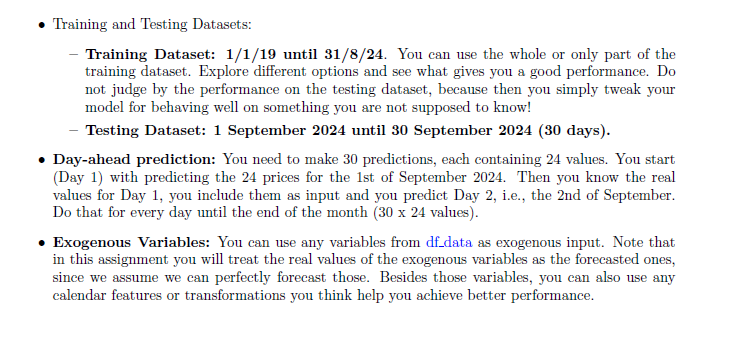

##### Defining the time series. It is assumed, that september 2023 is similar to september 2024, the analysis is therefore based on 2023

In [ ]:
#Define training and testing periods
train_start = '2022-10-01'
test_start = '2023-09-01'
test_end = '2023-10-01'


# Split the data from Elspotprices2nd
train = df_prices[(df_prices['HourUTC'] >= train_start) & (df_prices['HourUTC'] < test_start)]
test = df_prices[(df_prices['HourUTC'] >= test_start) & (df_prices['HourUTC'] < test_end)]

# Split the data from ProdConData
train_set_P = df_data[(df_prices['HourUTC'] >= train_start) & (df_data['HourUTC'] < test_start)]
test_set_P = df_data[(df_prices['HourUTC'] >= test_start) & (df_data['HourUTC'] < test_end)]
n = len(train['SpotPriceDKK'])
N = len(df_prices['SpotPriceDKK'])
df_data['SpotPriceDKK'] = df_prices["SpotPriceDKK"]

#### Firstly daily and weekly ACF and PACF is found, to get an estimate on what p and q has to be:

##### Daily

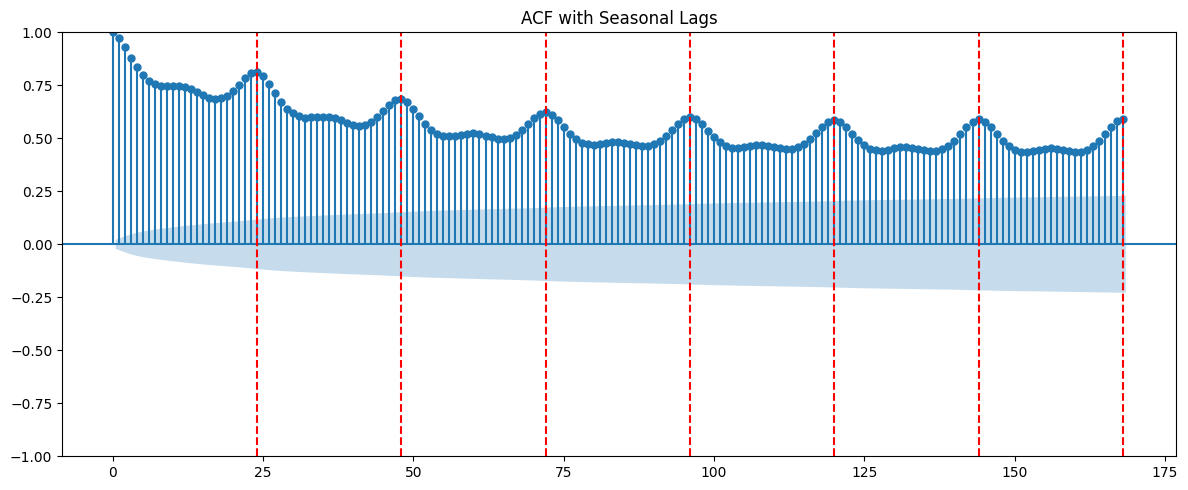

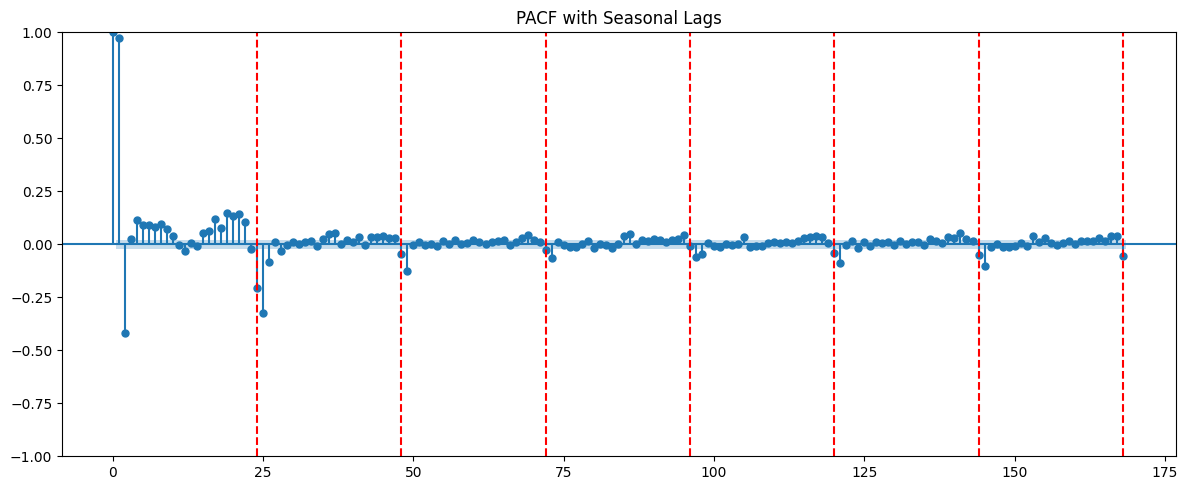

In [ ]:
seasonal_period = 24  # e.g., weekly seasonality for hourly data
max_lags = 24 * 7     # show 7 seasonal cycles

# ACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("ACF with Seasonal Lags")
plt.tight_layout()
plt.show()

# PACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, method='ywm', ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("PACF with Seasonal Lags")
plt.tight_layout()
plt.show()


##### Weekly

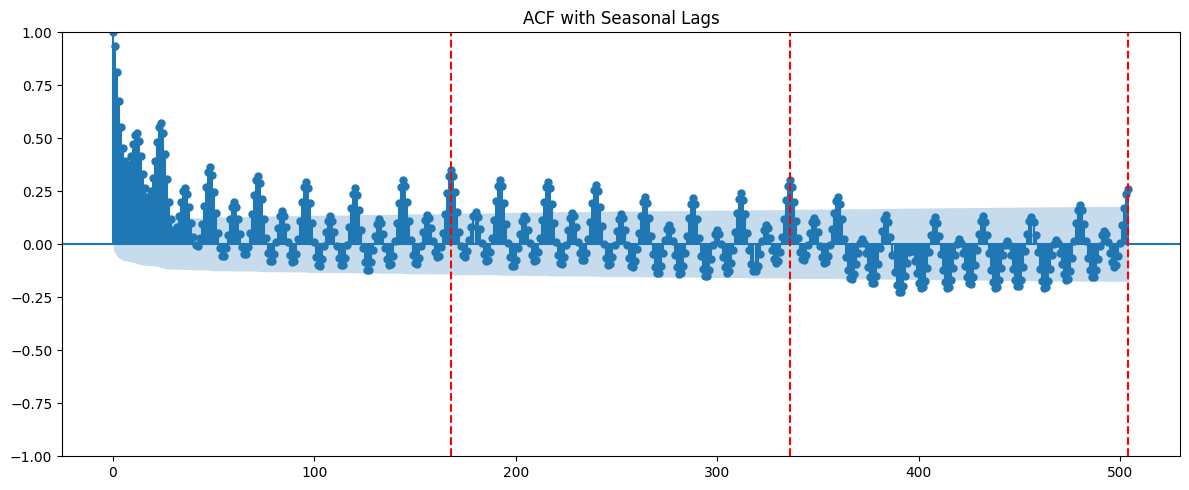

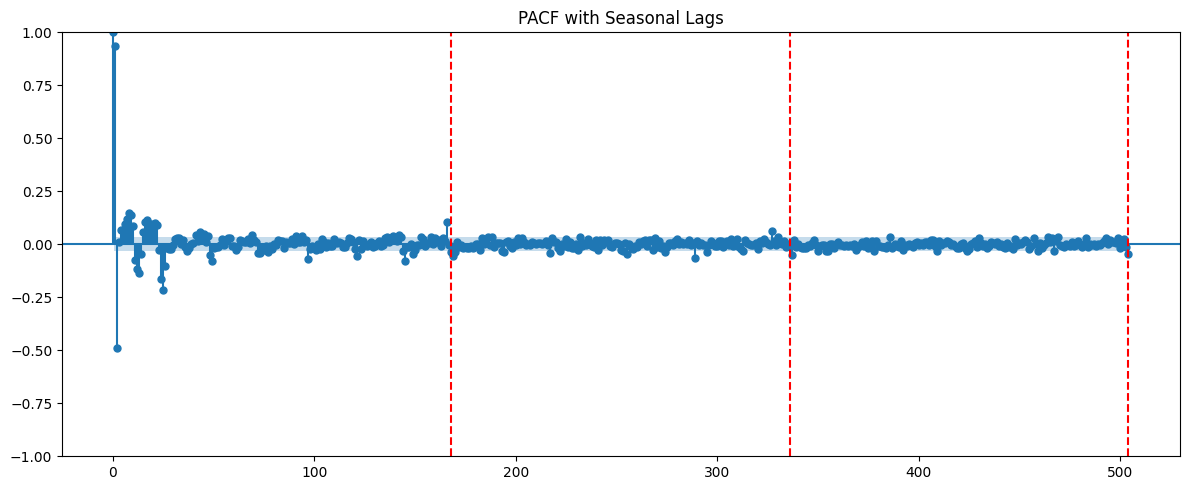

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

seasonal_period = 168  # e.g., weekly seasonality for hourly data
max_lags = 168 * 3     # show 3 seasonal cycles

# ACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("ACF with Seasonal Lags")
plt.tight_layout()
plt.show()

# PACF plot with seasonal markers
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(train['SpotPriceDKK'], lags=max_lags, alpha=0.05, method='ywm', ax=ax)
for lag in range(seasonal_period, max_lags + 1, seasonal_period):
    ax.axvline(x=lag, color='red', linestyle='--')
ax.set_title("PACF with Seasonal Lags")
plt.tight_layout()
plt.show()


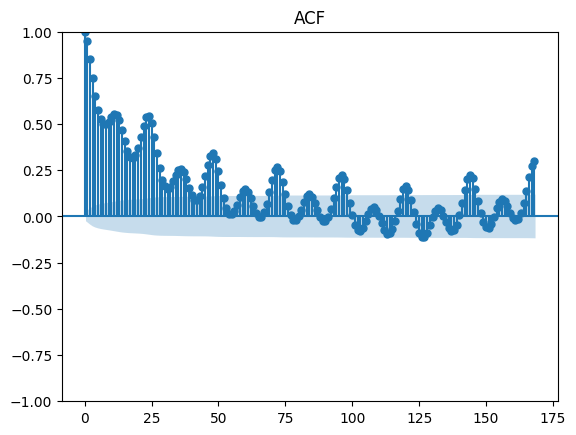

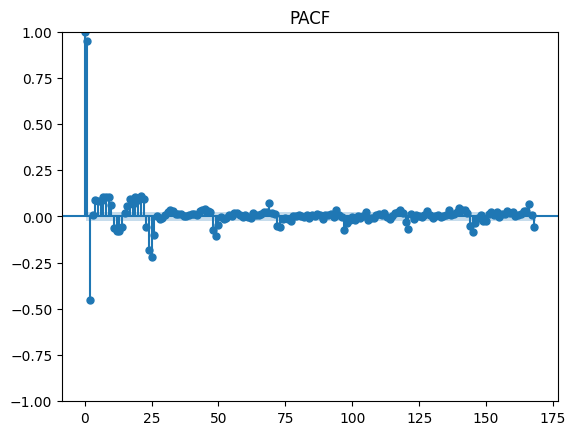

In [ ]:
# Check ACF plot
pm.plot_acf(train['SpotPriceDKK'], lags=168, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(train['SpotPriceDKK'], method='ywm', lags=168, title = "PACF", alpha = 0.05);


## Task 1

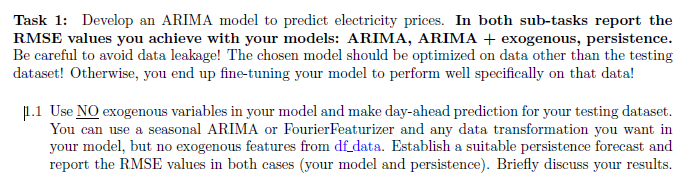

### Differentiating to make the time series stationary

Text(0, 0.5, 'x')

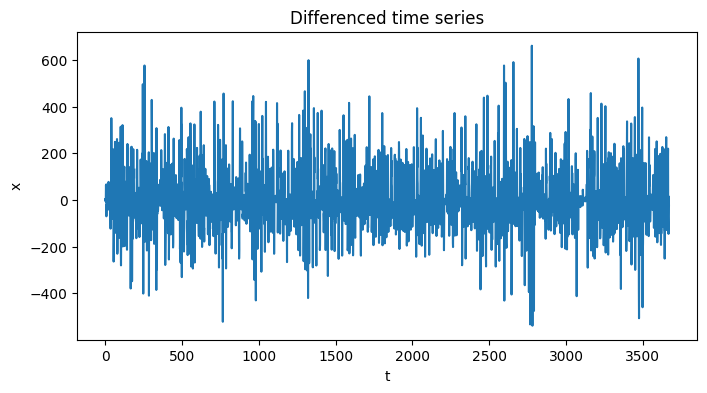

In [ ]:
# Calculate the first difference

train['Diff'] = train['SpotPriceDKK'].diff()
diff_data = np.diff(train['SpotPriceDKK'])

# Plot the result
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Differenced time series")
plt.plot(range(0,n-1), diff_data)
plt.xlabel("t")
plt.ylabel("x")

##### Diff

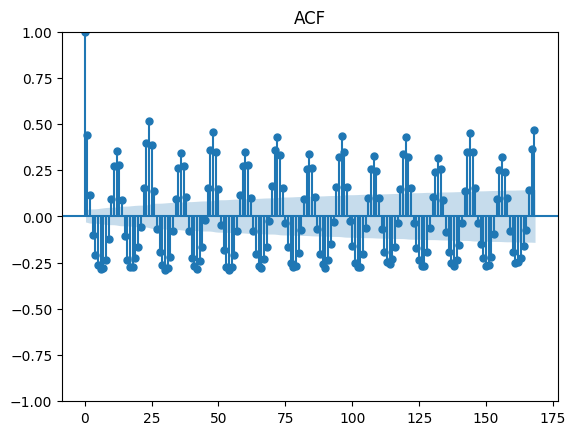

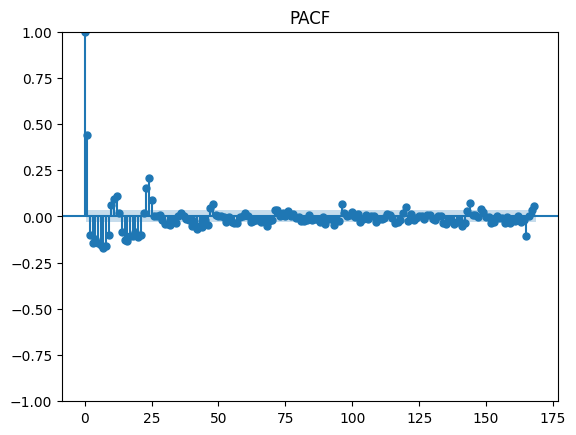

In [ ]:
# Check ACF plot
pm.plot_acf(diff_data, lags=168, title = "ACF", alpha = 0.05);
# Check the PACF plot
pm.plot_pacf(diff_data, method='ywm', lags=168, title = "PACF", alpha = 0.05);


## Deducing which model order to use

#### Auto models

In [ ]:
# # auto_arima search

# model = pm.auto_arima(
#     train['SpotPriceDKK'],         # your time series
#     start_p=0, max_p=3,             # non-seasonal AR
#     start_q=0, max_q=3,             # non-seasonal MA
#     d=None,                         # choose d 
#     seasonal=True,
#     start_P=0, max_P=3,             # seasonal AR
#     start_Q=0, max_Q=3,             # seasonal MA
#     D=None,                         # choose D
#     m=24,                           # seasonal period - one day
#     trace=True,                     # print models tried
#     error_action='ignore',          # skip models that fail
#     suppress_warnings=True,         # silence warnings
#     stepwise=True,                  # stepwise search to speed things up
#     n_fits=50                       # limit total fits (optional)
# )



In [ ]:
# Using autoarima on the training set
model = pm.auto_arima(train['SpotPriceDKK'], trace = True, seasonal = True, stepwise=True, maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=69924.135, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71490.028, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70396.886, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=70505.536, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71488.034, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=70285.758, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=70182.320, Time=0.89 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=69892.826, Time=0.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=69890.733, Time=0.98 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=70251.640, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=69862.311, Time=1.59 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=70160.744, Time=0.38 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=69859.359, Time=1.70 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=70079.923, Time=0.56 sec
 ARIMA(5,1,2)(0,0,0

In [ ]:
# Using autoarima on the differentiated data
model2 = pm.auto_arima(diff_data, 
                       trace = True, 
                       seasonal = True, 
                       stepwise=True, 
                       maxiter=10)

NameError: name 'diff_data' is not defined

ARIMA(1,0,2) på diff data er det bedste. Dette kan også ses ved 

#### Task 1,1

#### Laver en diagnostics

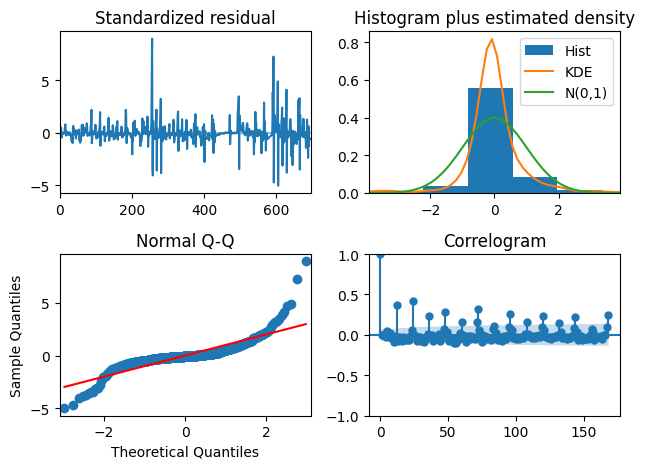

Summary of differentiated data
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  697
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -4674.222
Date:                Thu, 10 Apr 2025   AIC                           9364.444
Time:                        17:01:09   BIC                           9400.807
Sample:                             0   HQIC                          9378.504
                                - 697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2238      0.961     -0.233      0.816      -2.108       1.661
ar.L1          1.1147      0.029     37.970      0.000       1.057       1.172
ar.L2         -0.4555

In [ ]:
model = pm.arima.ARIMA(order=(5,1,1))
model.fit(test['SpotPriceDKK'])
model_diagnostics = model.plot_diagnostics(lags=168, fig=plt.figure())
plt.tight_layout()
plt.show()
print("Summary of differentiated data")
print(model.summary())

Kigger på Ljung-Box som skal være lille, en prob som er høj og AIC og BIC som er lave

##### Her laver jeg funktionen i en uge uden at putte den i en funktion

In [ ]:
frc_values = []
train_cutout = train['SpotPriceDKK'].values[1:168]
test_cutout = test['SpotPriceDKK'].values[1:168]

model =pm.arima.ARIMA(order=(5,1,1)) 
model.fit(train_cutout)

 
for k in range(len(test_cutout)):
    m = model.predict(1)[0]
    frc_values.append(m)
    model.update(test[k])

rmse_AR = sqrt(mean_squared_error(test_cutout, frc_values))
MAE_AR = mean_absolute_error(test_cutout, frc_values)

print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

##### Laver forecaster funktion

In [ ]:
model_forsøg = pm.arima.ARIMA((1,1,1),(0,1,1,24))

In [ ]:
def Create_Sarima(train, order=None, seasonal_order=None, X_train = None):
    # Create the model
    if seasonal_order is None:
        if order is None:
            print("Non seasonal model with no order specified")
            print("Using auto_arima to find the best order")
            model = pm.auto_arima(train, seasonal=False, X=X_train, maxiter=10)
        else:
            print("Non seasonal model with order specified")
            print("Using the specified order")
            model = pm.arima.ARIMA(order=order,seasonal=False)
            model.fit(train,X=X_train)
    elif order is None or type(seasonal_order) is not tuple:
        try:
            m = seasonal_order[-1]
        except TypeError:
            m = seasonal_order
        print("Seasonal model missing order")
        print("Using auto_arima to find the best order with m=", m)
        model = pm.auto_arima(train, seasonal=True, m=m,X=X_train, maxiter=5)
    else:
        m = seasonal_order[-1]
        print("Seasonal model with order specified")
        print("Using the specified order with m=", m)
        model = pm.arima.ARIMA(order=order, seasonal_order=seasonal_order)
        model.fit(train,X=X_train)
        
    print(model.summary())
    return model

def Create_Fourier_Pipe(train, m=24*7,k=24,X_train=None):
    pipe = pipeline.Pipeline([
    ("fourier", pm.preprocessing.FourierFeaturizer(m=m, k = k)),
    ("arima", arima.AutoARIMA(stepwise=False, trace = False, error_action="ignore",
                              seasonal=False, maxiter=10, 
                              suppress_warnings=True))])
    pipe.fit(train,X=X_train)
    print(pipe.summary())
    return pipe

def Forecaster(test, model, n=1,X_test=None):
    
    # Split the dataset into training and testing dataset
    frc_values = []
    X_f = None
    
    # Perform the forecasts
    for k in range(int(len(test)/n)):
        print("Forecasting period", k+1,"/",int(len(test)/n))
        if X_test is not None:
            X_f = np.column_stack([np.arange(1, n+1), 
                           X_test[k*n:(k+1)*n]])
        frc = model.predict(n_periods=n, X=X_f)
        frc_values.extend(frc)
        model.update(test[k*n:(k+1)*n], X=X_f)

    # Calculate error metrics
    rmse_AR = sqrt(mean_squared_error(test, frc_values))
    MAE_AR = mean_absolute_error(test, frc_values)
    print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
    print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))
    
    return frc_values

def persistence(train, test, n=1):
    # Split the dataset into training and testing dataset
    frc_values = []
    
    # Perform the forecasts
    for k in range(int(len(test)/n)):
        print("Forecasting period", k+1,"/",int(len(test)/n))
        frc = train[-n:]
        frc_values.extend(frc)
        train = np.concatenate((train, test[k*n:(k+1)*n]))
        
    # Calculate error metrics
    rmse_AR = sqrt(mean_squared_error(test, frc_values))
    MAE_AR = mean_absolute_error(test, frc_values)
    print("The model gives an RMSE of", float("{:.3f}".format(rmse_AR)))
    print("The model gives an MAE of", float("{:.3f}".format(MAE_AR)))
    
    return frc_values

    
def Plotting(train, test, forecast):
    # Plot the forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(train)), train, label="Historical data")
    plt.plot(range(len(train), len(train) + len(test)), test, label="Real values")
    plt.plot(range(len(train), len(train) + len(test)), forecast, label="Forecasted values")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Forecasting Performance")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Plot the forecasts
    plt.figure(figsize=(4*1.25,3*1.25), dpi = 200)
    plt.plot(range(0,len(train)), train)
    plt.plot(range(len(train)+1,len(train)+len(test)+1), test)
    plt.plot(range(len(train)+1,len(train)+len(test)+1), forecast)
    plt.xlim([len(train)-50,len(train)+len(test)])
    plt.xlabel("Hour")
    plt.ylabel("Spot price DKK")
    plt.title("Forecasting performance")
    plt.legend(["Historical data", "Real values", "Forecasted values"])
    plt.tight_layout()
    plt.show()
    # Plot the residuals (forecasting errors)
    plt.figure()
    residuals = [a - b for a, b in zip(test, forecast)]
    plt.plot(range(0,len(residuals)), residuals)
    plt.title("Forecasting errors")
    plt.xlabel("t")
    plt.ylabel("residual")
    plt.tight_layout()
    plt.show()    


In [ ]:
model = Create_Sarima(train['SpotPriceDKK'])
result = Forecaster(test['SpotPriceDKK'], model, 24)

Non seasonal model with no order specified
Using auto_arima to find the best order
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3672
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -21993.050
Date:                Wed, 16 Apr 2025   AIC                          43998.101
Time:                        13:21:11   BIC                          44035.350
Sample:                             0   HQIC                         44011.362
                               - 3672                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2520      0.019     67.654      0.000       1.216       1.288
ar.L2         -0.4151      0.022    -19.198     

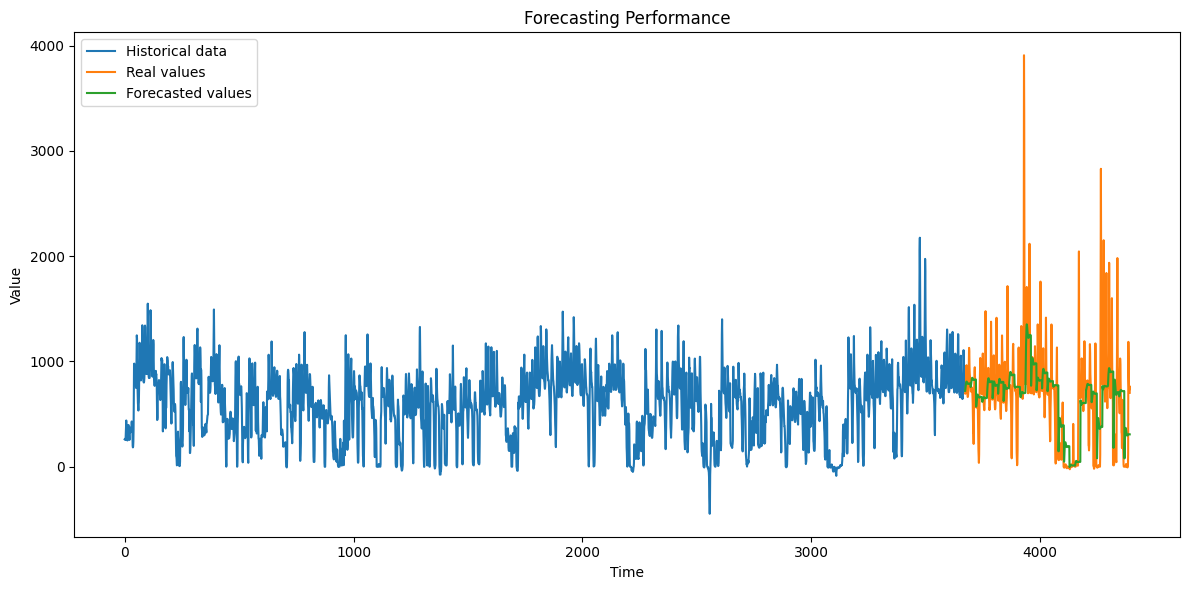

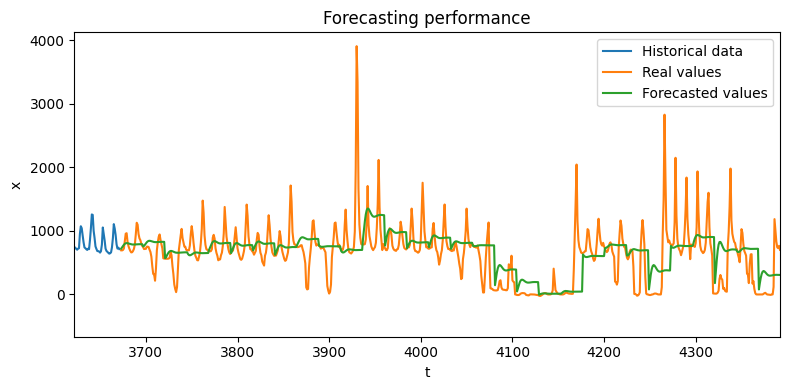

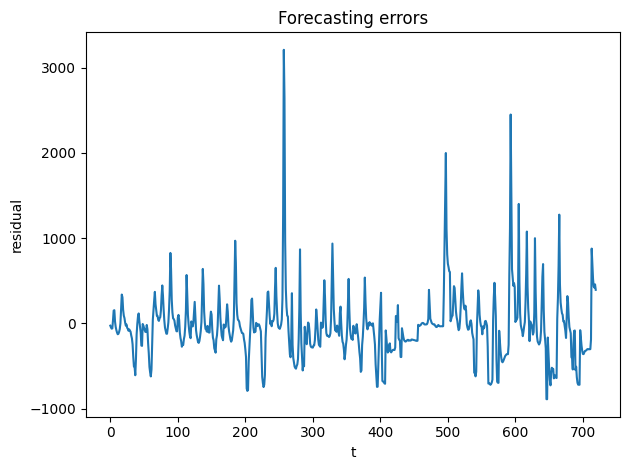

In [ ]:
Plotting(train['SpotPriceDKK'], test['SpotPriceDKK'], result)

In [ ]:
model = Create_Sarima(train, order=(1,1,2),seasonal_order=(0,1,1,24))
result = Forecaster(test, model, 24)

Seasonal model with order specified
Using the specified order with m= 24
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 8040
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -49144.581
Date:                              Mon, 21 Apr 2025   AIC                          98301.162
Time:                                      11:52:17   BIC                          98343.096
Sample:                                           0   HQIC                         98315.514
                                             - 8040                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -6.96e-06    

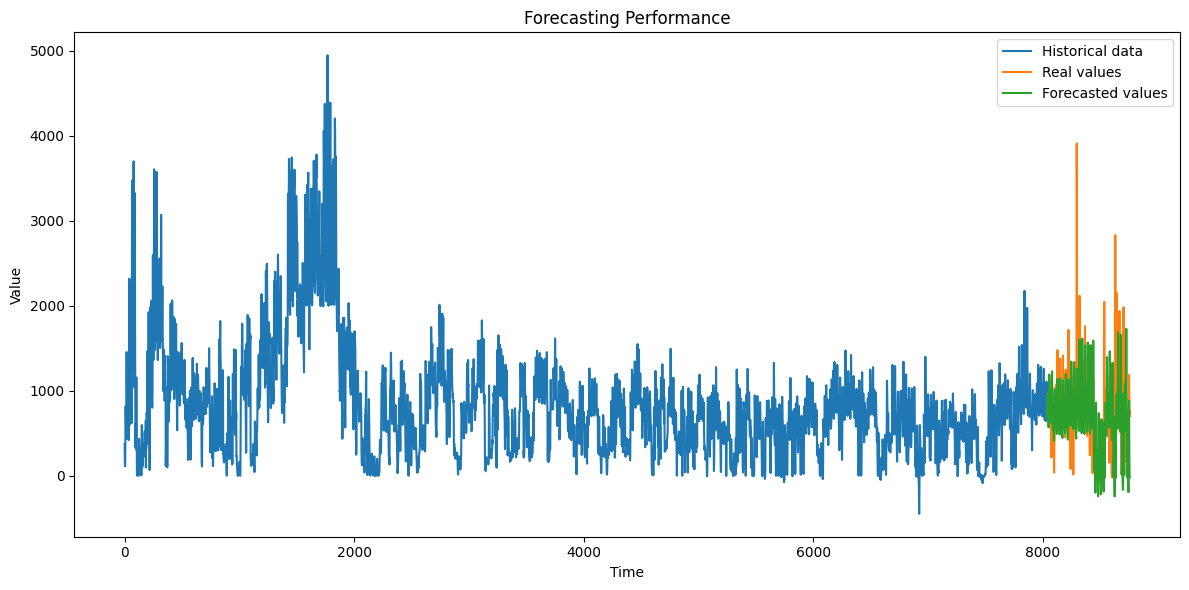

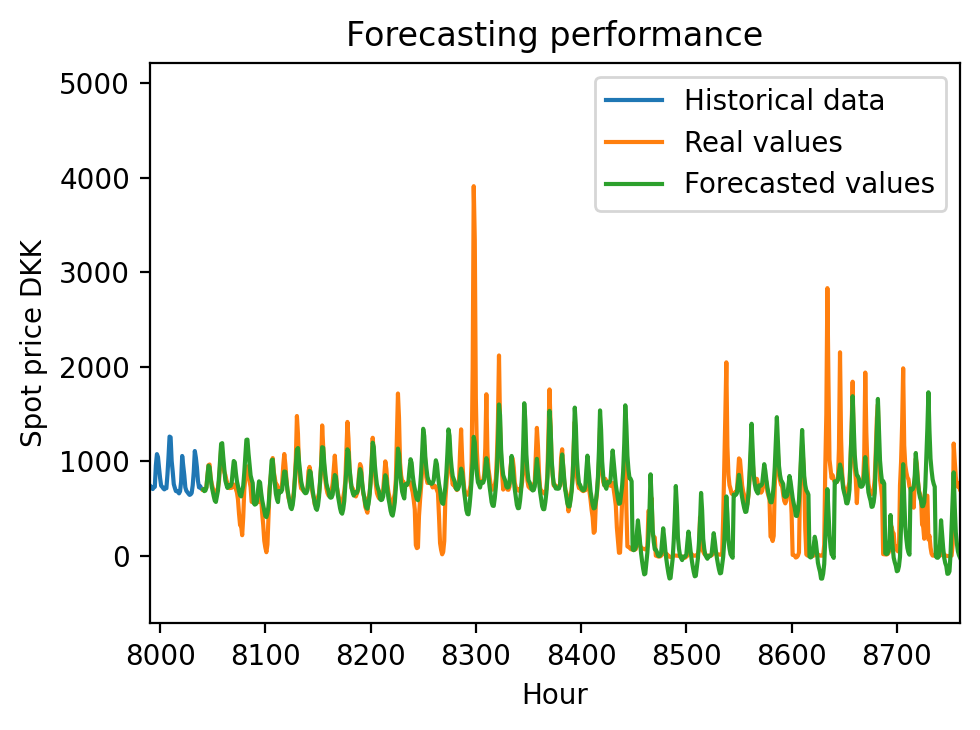

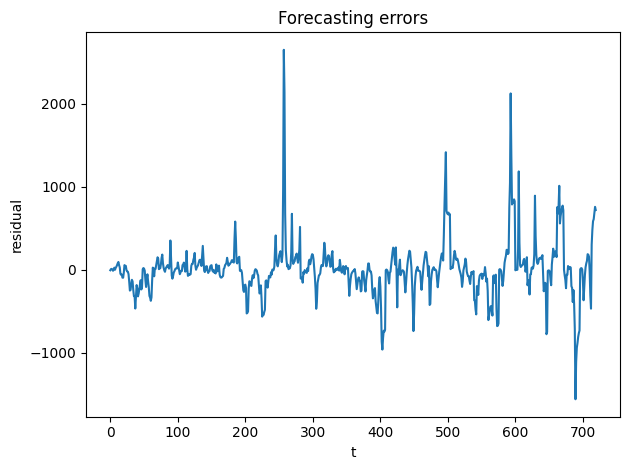

In [ ]:
Plotting(train, test, result)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8040
Model:               SARIMAX(1, 1, 3)   Log Likelihood              -49934.041
Date:                Mon, 21 Apr 2025   AIC                          99976.082
Time:                        12:15:44   BIC                         100353.653
Sample:                             0   HQIC                        100105.287
                               - 8040                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0014      0.109      0.012      0.990      -0.213       0.215
FOURIER_S168-0    -87.1725     32.792     -2.658      0.008    -151.444     -22.901
FOURIER_C168-0    -69.1366     3

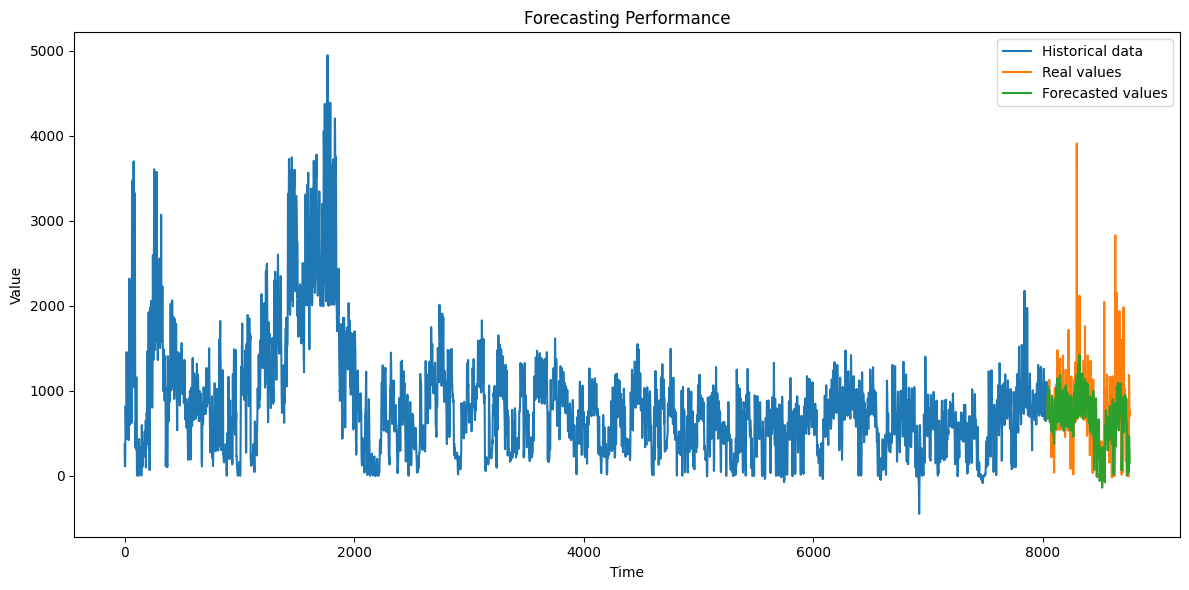

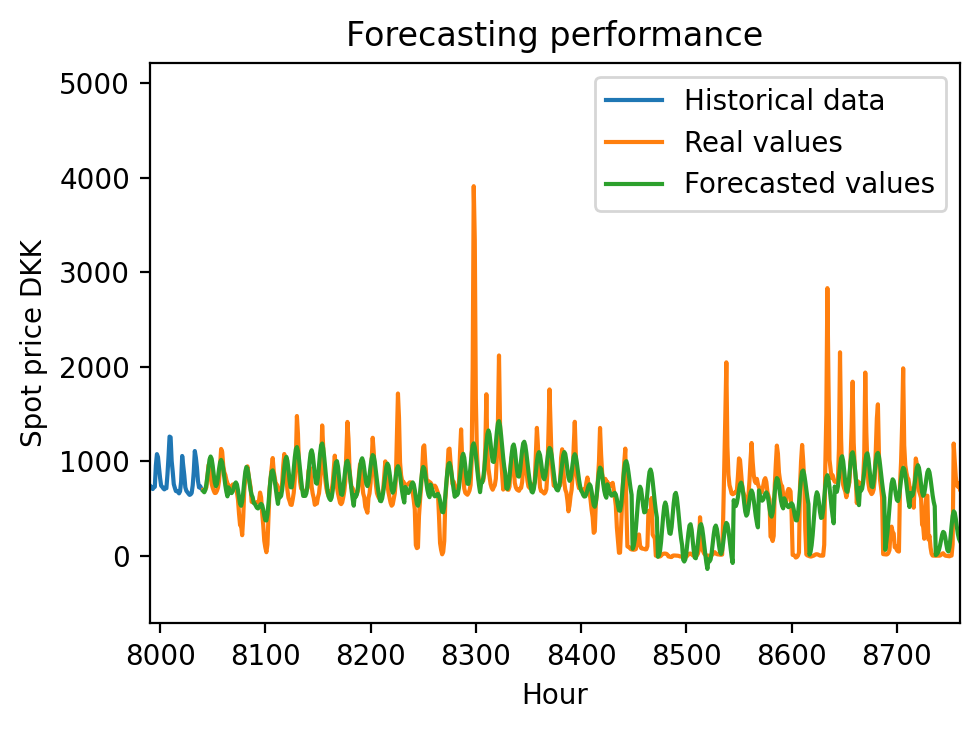

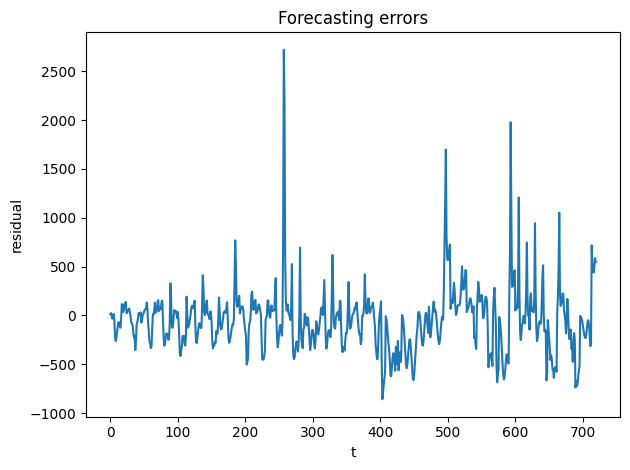

In [ ]:
model = Create_Fourier_Pipe(train['SpotPriceDKK'].values, m=24*7, k=24)
result = Forecaster(test['SpotPriceDKK'].values, model, 24)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

Forecasting period 1 / 30
Forecasting period 2 / 30
Forecasting period 3 / 30
Forecasting period 4 / 30
Forecasting period 5 / 30
Forecasting period 6 / 30
Forecasting period 7 / 30
Forecasting period 8 / 30
Forecasting period 9 / 30
Forecasting period 10 / 30
Forecasting period 11 / 30
Forecasting period 12 / 30
Forecasting period 13 / 30
Forecasting period 14 / 30
Forecasting period 15 / 30
Forecasting period 16 / 30
Forecasting period 17 / 30
Forecasting period 18 / 30
Forecasting period 19 / 30
Forecasting period 20 / 30
Forecasting period 21 / 30
Forecasting period 22 / 30
Forecasting period 23 / 30
Forecasting period 24 / 30
Forecasting period 25 / 30
Forecasting period 26 / 30
Forecasting period 27 / 30
Forecasting period 28 / 30
Forecasting period 29 / 30
Forecasting period 30 / 30
The model gives an RMSE of 419.842
The model gives an MAE of 252.109


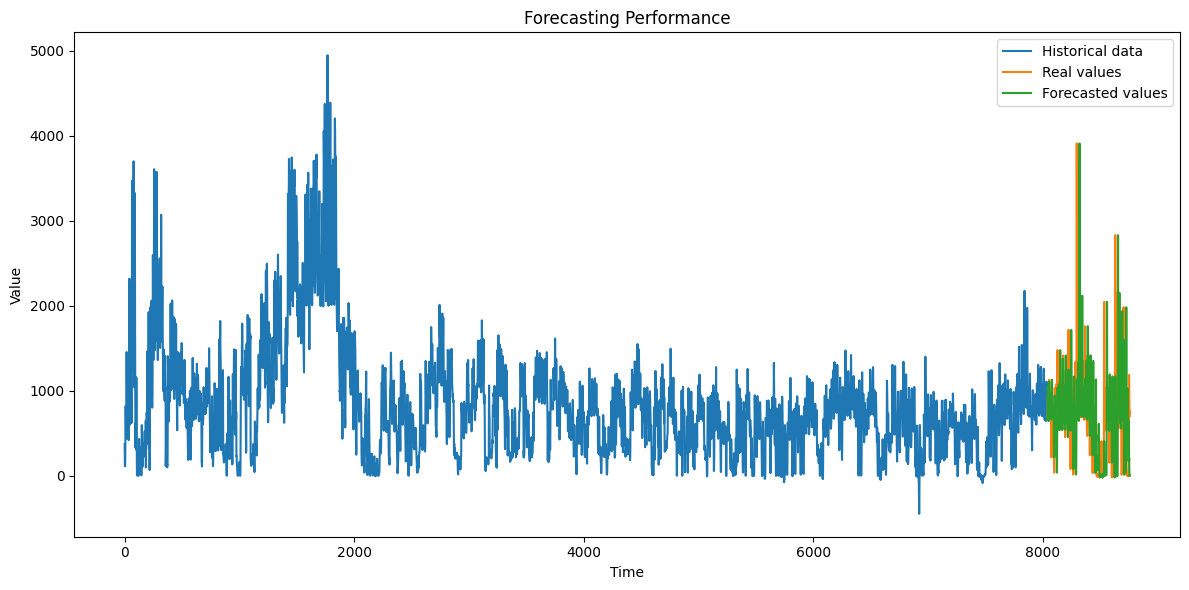

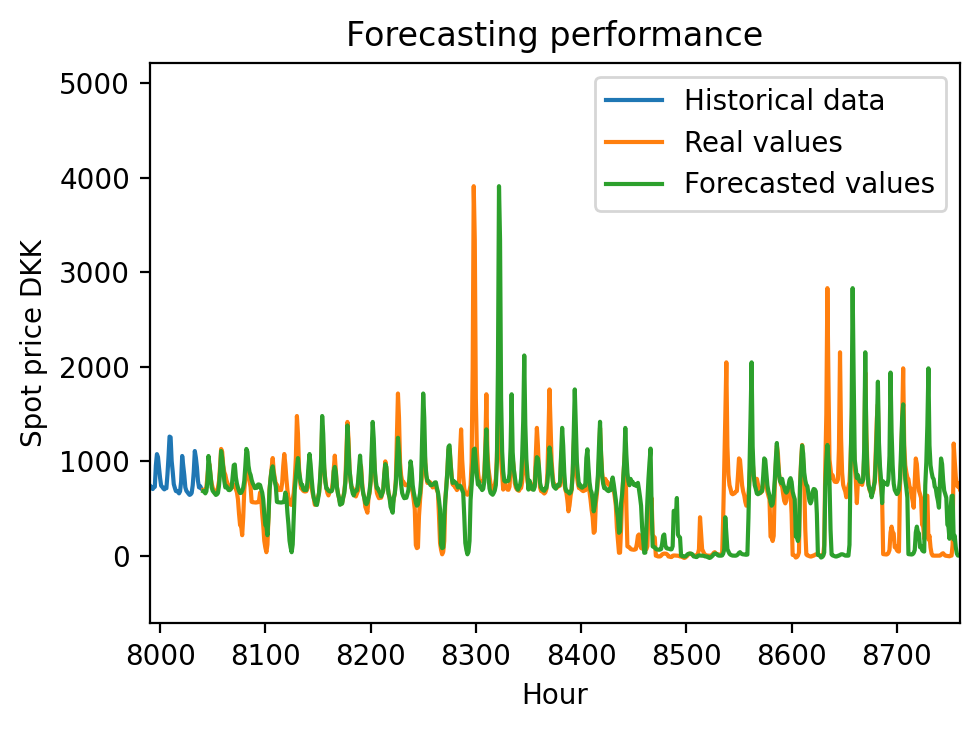

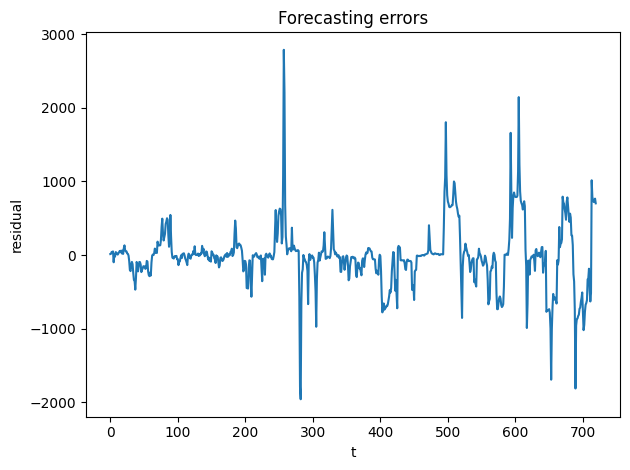

In [ ]:
result = persistence(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, 24)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

#### Et forsøg på Task 1.2 med exogenous variables

Det betyder, at persistence-modellen faktisk klarede sig bedre end ARIMA-modellen med eksterne input på den første dag

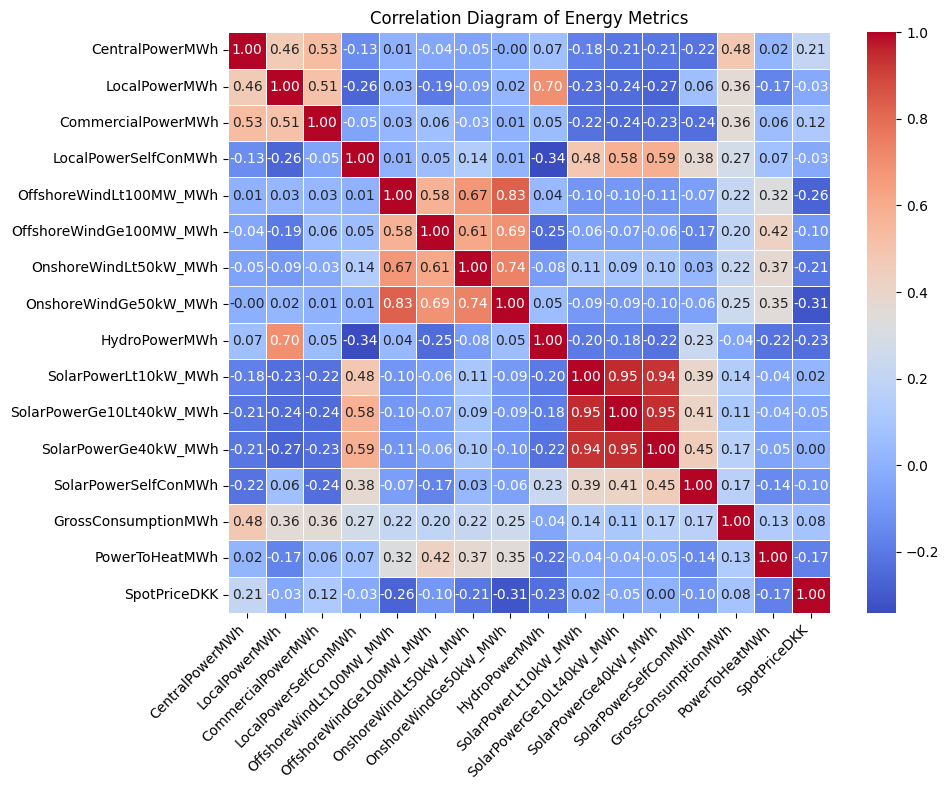

In [ ]:
import seaborn as sns

# Select numeric columns for correlation analysis
numeric_data = df_data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

Targets = ['SpotPriceDKK']

Features = ['CentralPowerMWh',
            'LocalPowerMWh',
            'CommercialPowerMWh',
            'LocalPowerSelfConMWh',
            'OffshoreWindLt100MW_MWh',
            'OffshoreWindGe100MW_MWh',
            'OnshoreWindLt50kW_MWh',
            'OnshoreWindGe50kW_MWh',
            'HydroPowerMWh',
            'SolarPowerLt10kW_MWh',
            'SolarPowerGe10Lt40kW_MWh',
            'SolarPowerGe40kW_MWh',
            'SolarPowerSelfConMWh',
            'GrossConsumptionMWh',
            'PowerToHeatMWh',
            'SpotPriceDKK'
            ]


#corr_subset = correlation_matrix.loc[Features, Targets]
# Set up matplotlib figure
plt.figure(figsize=(10, 8))
#colorpalet = 'greens'
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#sns.heatmap(corr_subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set titles and labels
plt.title('Correlation Diagram of Energy Metrics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# We have chosen the exogenous variables based on a correlation heat map that showed high correlation with spotprices 
# The 3 highest correlated variables where all wind related and because they also correlates a lot with eachother we 
# chose these 3 which could give more diverse information 
Exovariables = ['OnshoreWindGe50kW_MWh', 'CentralPowerMWh']#, 'PowerToHeatMWh']


# Define input/output
X_train = train_set_P[Exovariables].values
X_test = test_set_P[Exovariables].values

""" # Define train/test split based on time
train_mask = (merged_df["HourUTC"] >= "2023-01-01") & (merged_df["HourUTC"] <= "2023-08-31")
test_mask = (merged_df["HourUTC"] >= "2023-09-01") & (merged_df["HourUTC"] <= "2023-09-30")

X_train = X_full[train_mask.values]
X_test = X_full[test_mask.values]
y_train = y_full[train_mask.values]
y_test = y_full[test_mask.values] """


# Add time index as a trend variable
X_train_ar = np.column_stack([np.arange(1,len(X_train)+1), X_train])


Seasonal model with order specified
Using the specified order with m= 24
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 8040
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -49007.295
Date:                              Mon, 21 Apr 2025   AIC                          98032.589
Time:                                      12:27:04   BIC                          98095.491
Sample:                                           0   HQIC                         98054.117
                                             - 8040                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001    

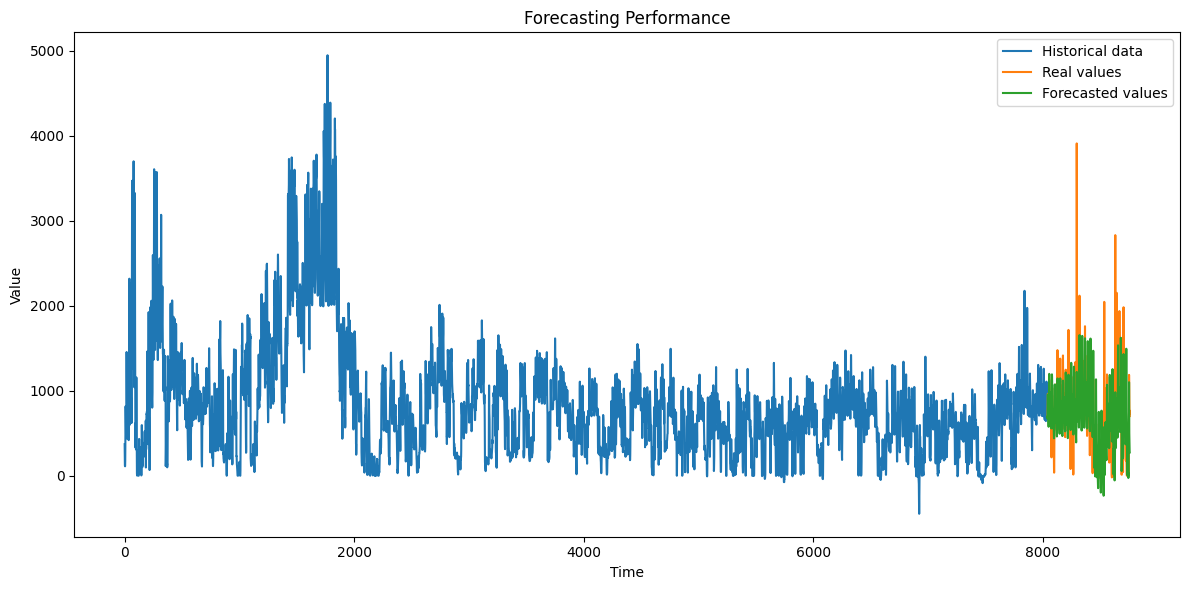

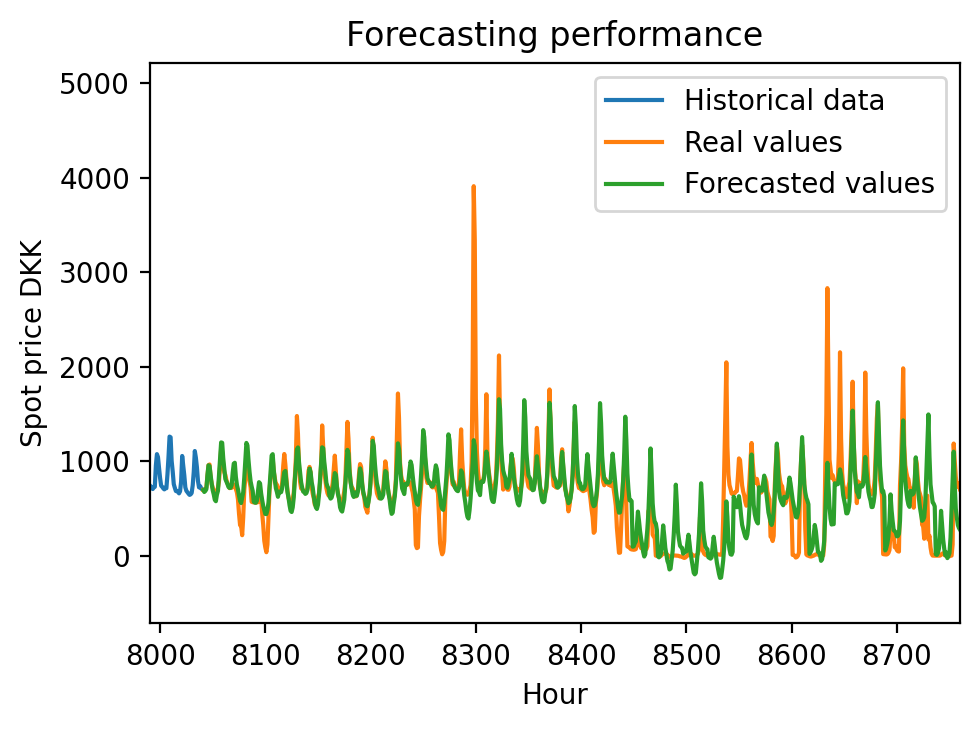

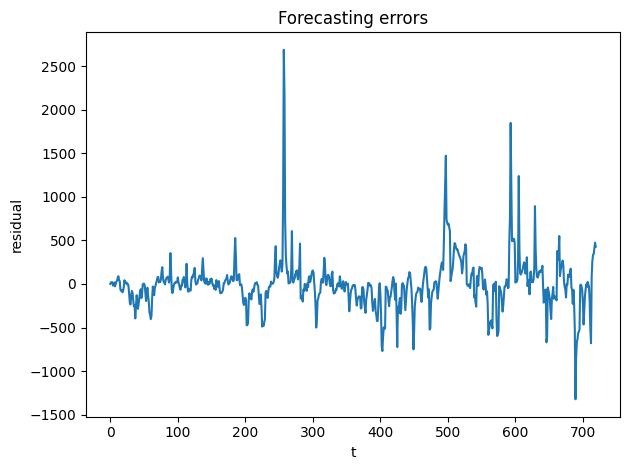

In [ ]:
model = Create_Sarima(train['SpotPriceDKK'].values,order=(1,1,2),seasonal_order=(0,1,1,24),X_train=X_train_ar)
result = Forecaster(test['SpotPriceDKK'].values, model,24,X_test=X_test)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

Seasonal model with order specified
Using the specified order with m= 24
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 8040
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -49007.130
Date:                              Mon, 21 Apr 2025   AIC                          98034.261
Time:                                      12:44:37   BIC                          98104.151
Sample:                                           0   HQIC                         98058.181
                                             - 8040                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002    

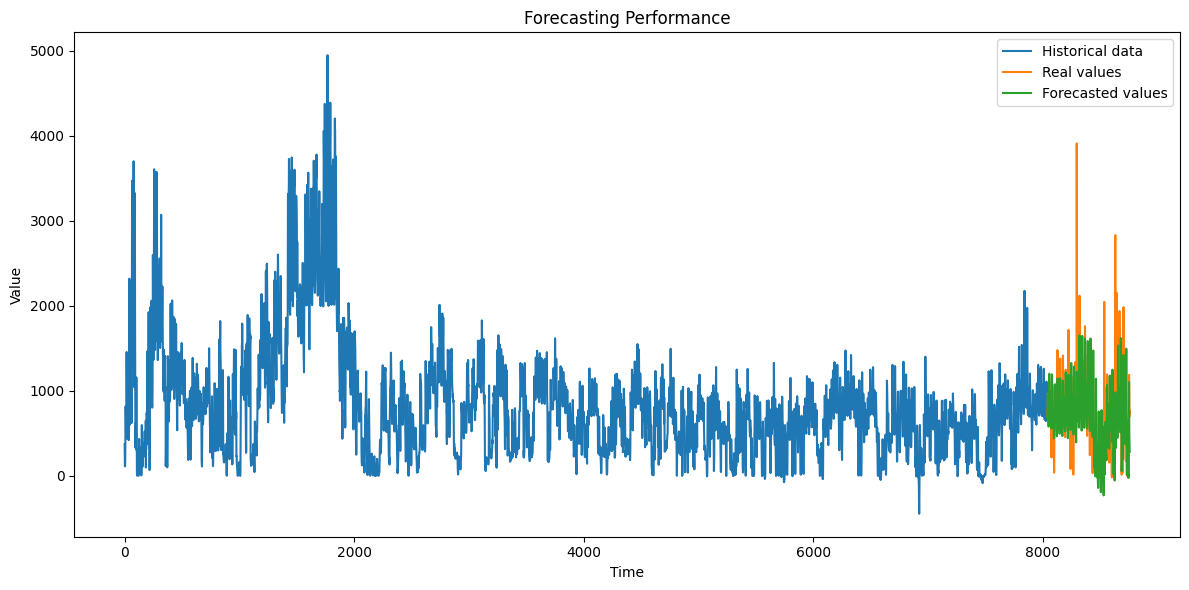

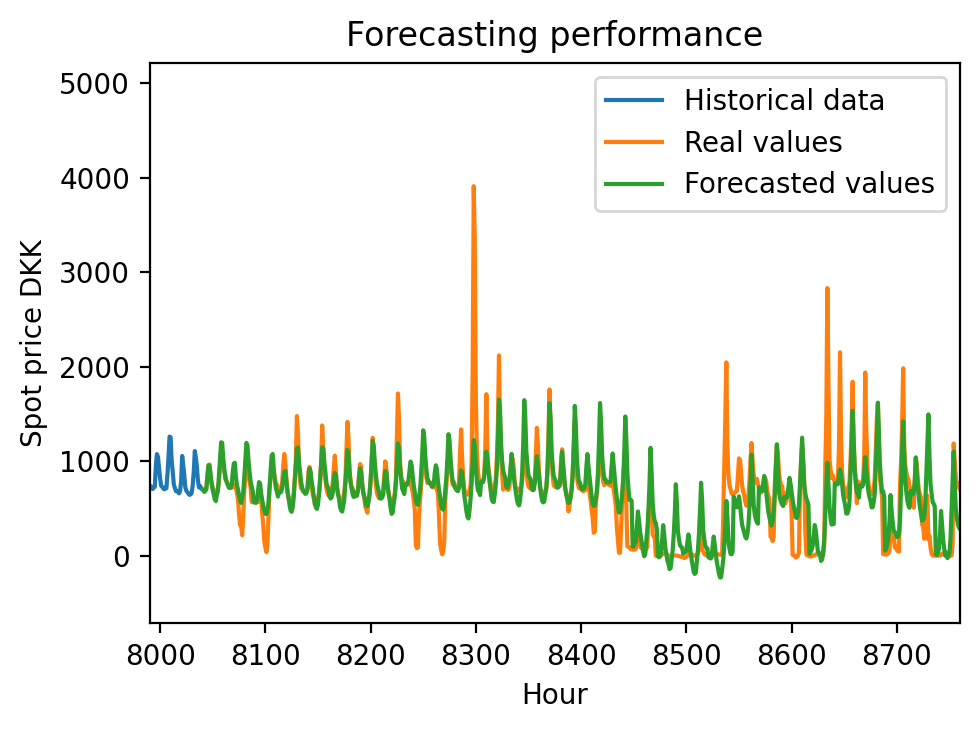

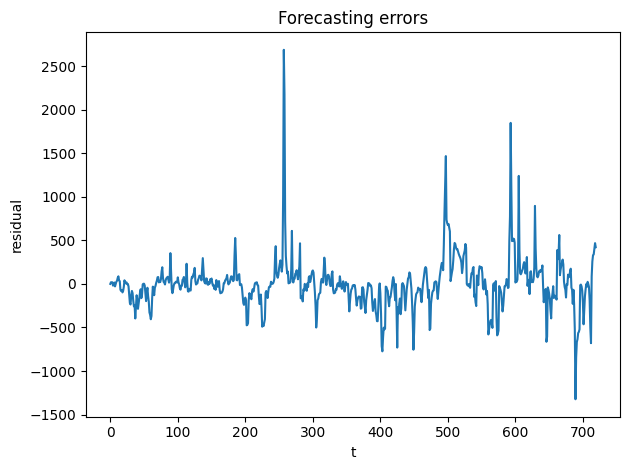

In [ ]:
Exovariables = ['OnshoreWindGe50kW_MWh', 'CentralPowerMWh', 'PowerToHeatMWh']
# Define input/output
X_train = train_set_P[Exovariables].values
X_test = test_set_P[Exovariables].values
X_train_ar = np.column_stack([np.arange(1,len(X_train)+1), X_train])
model = Create_Sarima(train['SpotPriceDKK'].values,order=(1,1,2),seasonal_order=(0,1,1,24),X_train=X_train_ar)
result = Forecaster(test['SpotPriceDKK'].values, model,24,X_test=X_test)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

Seasonal model with order specified
Using the specified order with m= 24
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 8040
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 24)   Log Likelihood              -49043.388
Date:                              Mon, 21 Apr 2025   AIC                          98102.776
Time:                                      13:01:52   BIC                          98158.689
Sample:                                           0   HQIC                         98121.912
                                             - 8040                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.687e-05    

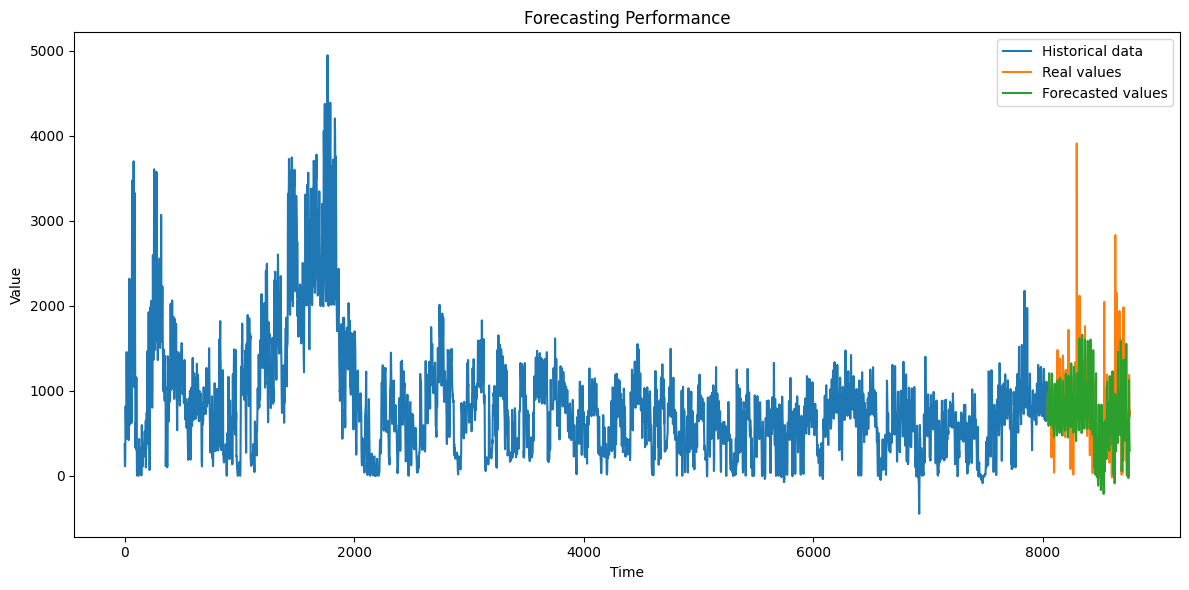

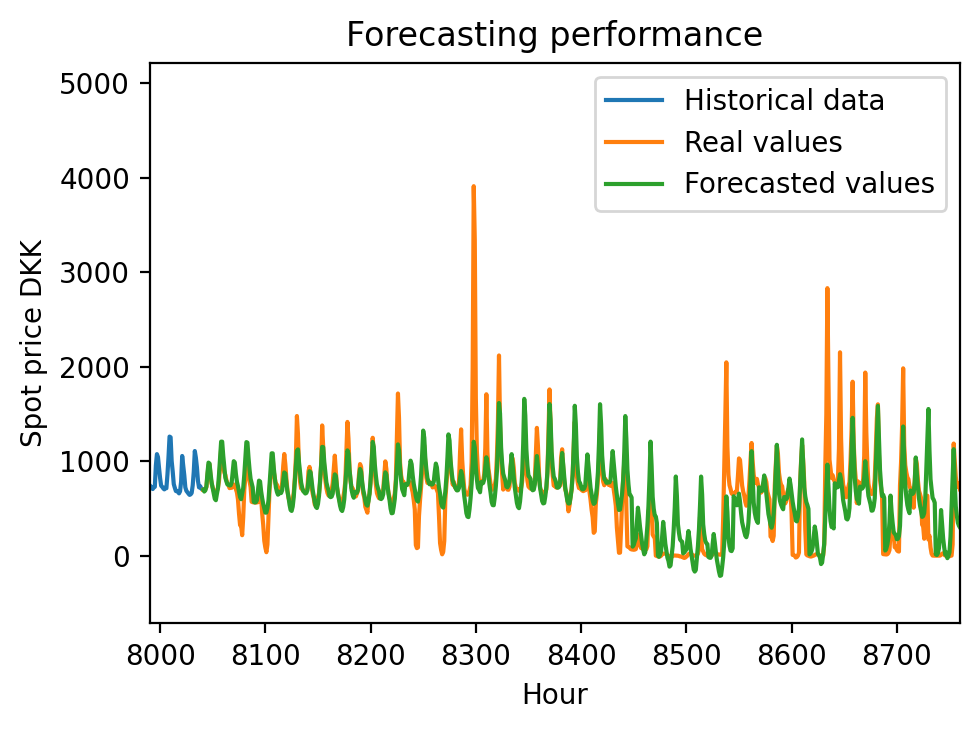

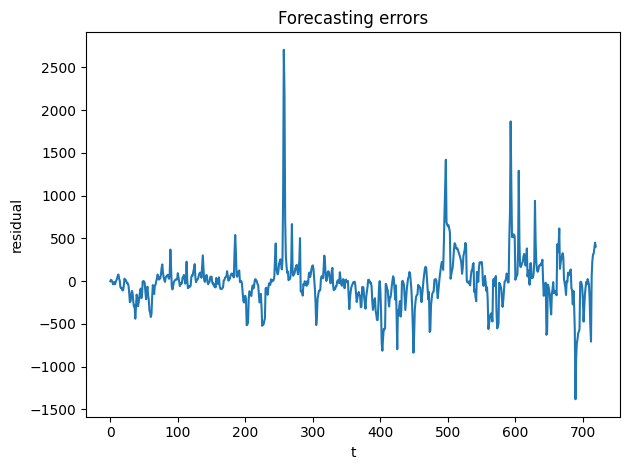

In [ ]:
Exovariables = ['OnshoreWindGe50kW_MWh']#, 'CentralPowerMWh', 'PowerToHeatMWh']
# Define input/output
X_train = train_set_P[Exovariables].values
X_test = test_set_P[Exovariables].values
X_train_ar = np.column_stack([np.arange(1,len(X_train)+1), X_train])
model = Create_Sarima(train['SpotPriceDKK'].values,order=(1,1,2),seasonal_order=(0,1,1,24),X_train=X_train_ar)
result = Forecaster(test['SpotPriceDKK'].values, model,24,X_test=X_test)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8040
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -50108.385
Date:                Mon, 21 Apr 2025   AIC                         100332.771
Time:                        13:19:41   BIC                         100738.317
Sample:                             0   HQIC                        100471.548
                               - 8040                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1211      0.038      3.214      0.001       0.047       0.195
x2            -0.4652      0.064     -7.219      0.000      -0.592      -0.339
x3             0.4699      0.049      9.581      0.0

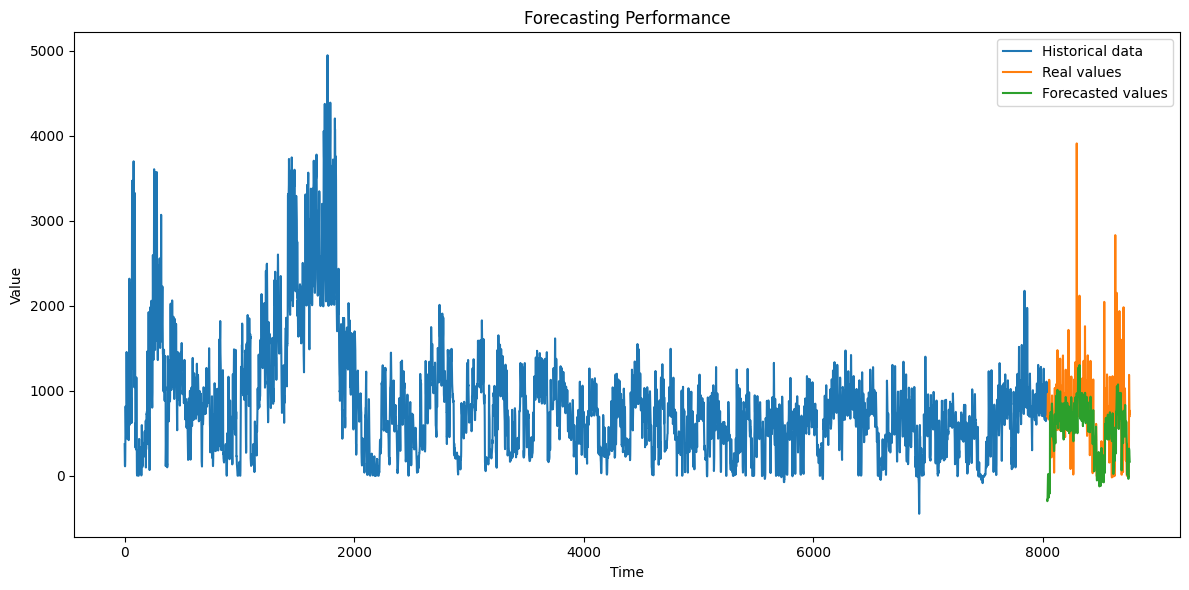

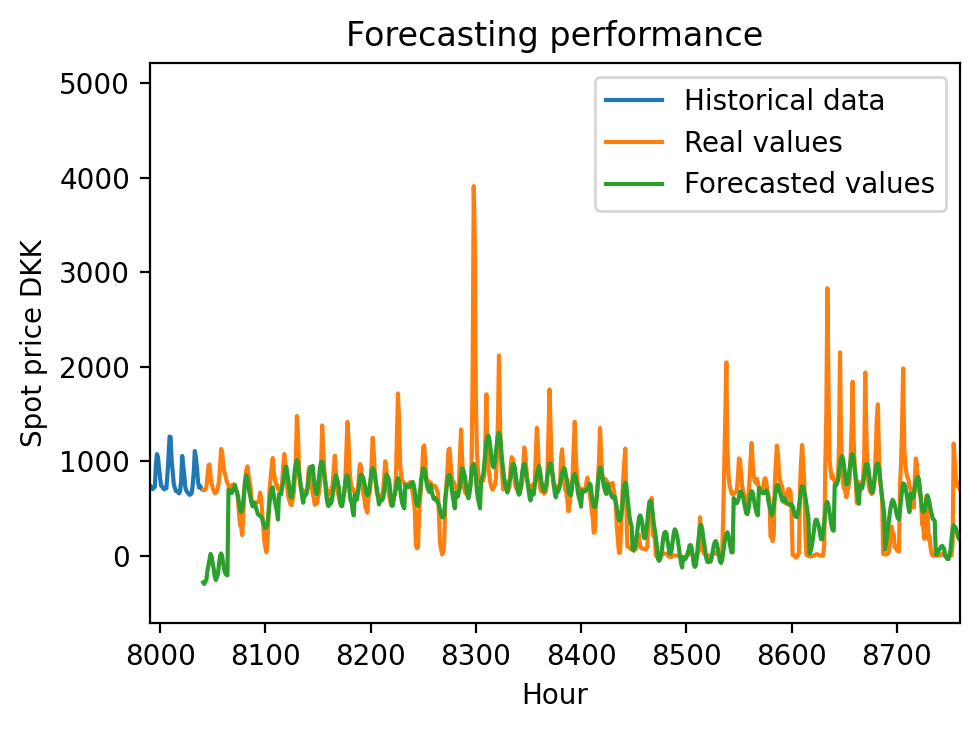

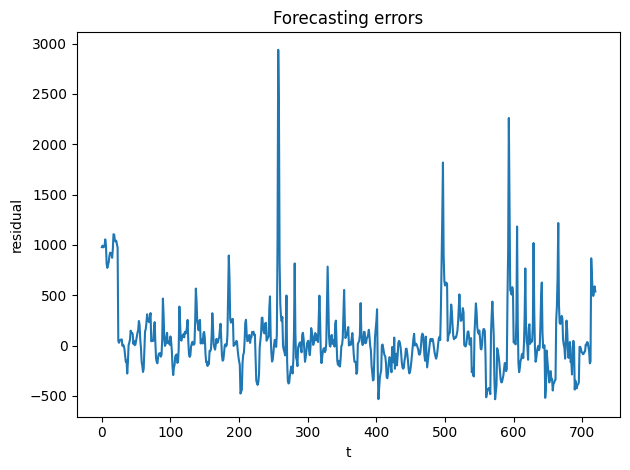

In [ ]:
Exovariables = ['OnshoreWindGe50kW_MWh', 'CentralPowerMWh', 'PowerToHeatMWh']
# Define input/output
X_train = train_set_P[Exovariables].values
X_test = test_set_P[Exovariables].values
X_train_ar = np.column_stack([np.arange(1,len(X_train)+1), X_train])
# Define and fit AutoARIMA pipeline
pipe = Create_Fourier_Pipe(train['SpotPriceDKK'].values, m=24*7, k=24,X_train=X_train_ar)
result = Forecaster(test['SpotPriceDKK'].values, pipe,24,X_test=X_test)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

Forecasting period 1 / 30
Forecasting period 2 / 30
Forecasting period 3 / 30
Forecasting period 4 / 30
Forecasting period 5 / 30
Forecasting period 6 / 30
Forecasting period 7 / 30
Forecasting period 8 / 30
Forecasting period 9 / 30
Forecasting period 10 / 30
Forecasting period 11 / 30
Forecasting period 12 / 30
Forecasting period 13 / 30
Forecasting period 14 / 30
Forecasting period 15 / 30
Forecasting period 16 / 30
Forecasting period 17 / 30
Forecasting period 18 / 30
Forecasting period 19 / 30
Forecasting period 20 / 30
Forecasting period 21 / 30
Forecasting period 22 / 30
Forecasting period 23 / 30
Forecasting period 24 / 30
Forecasting period 25 / 30
Forecasting period 26 / 30
Forecasting period 27 / 30
Forecasting period 28 / 30
Forecasting period 29 / 30
Forecasting period 30 / 30
The model gives an RMSE of 419.842
The model gives an MAE of 252.109


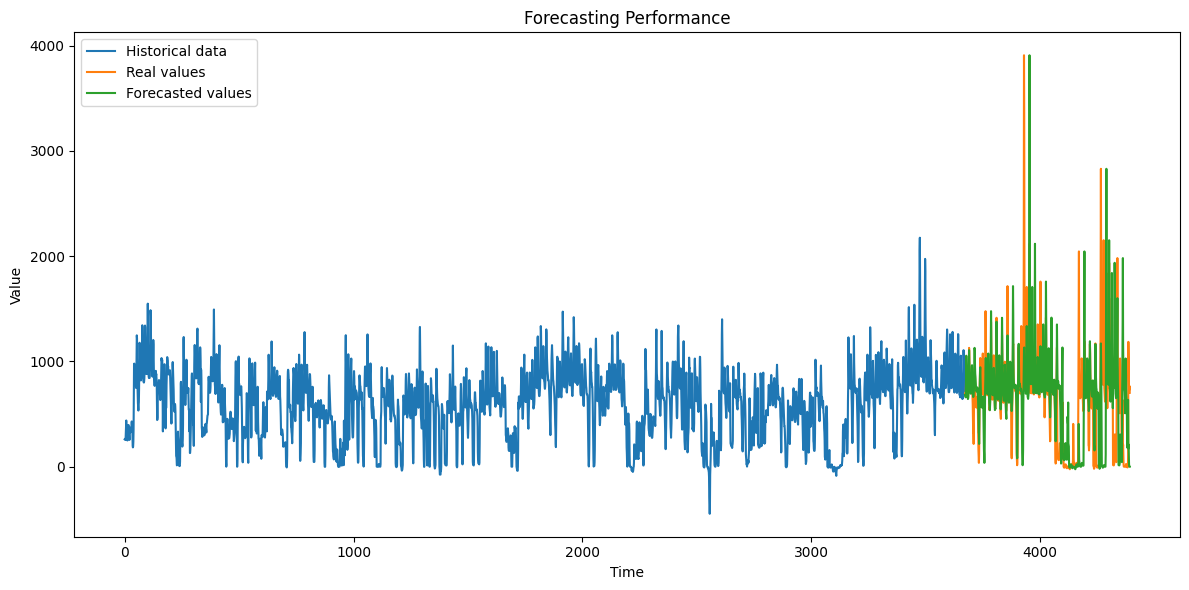

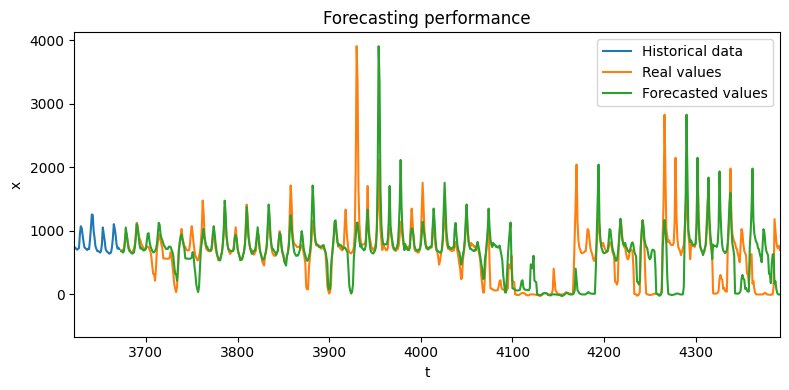

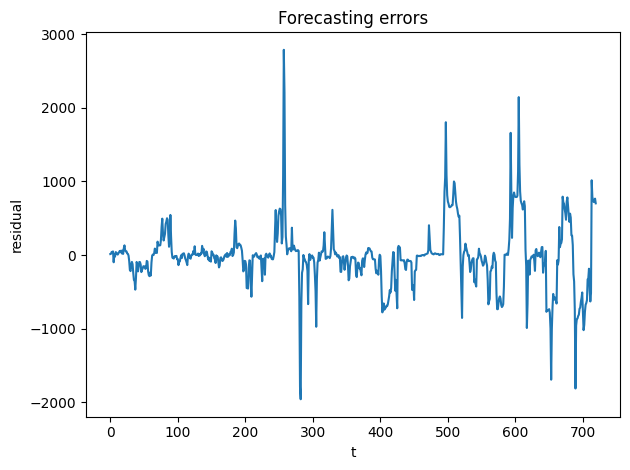

In [ ]:
result = persistence(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, 24)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'].values, result)

Forecasting period 1 / 4
Forecasting period 2 / 4
Forecasting period 3 / 4
Forecasting period 4 / 4
The model gives an RMSE of 501.848
The model gives an MAE of 293.427


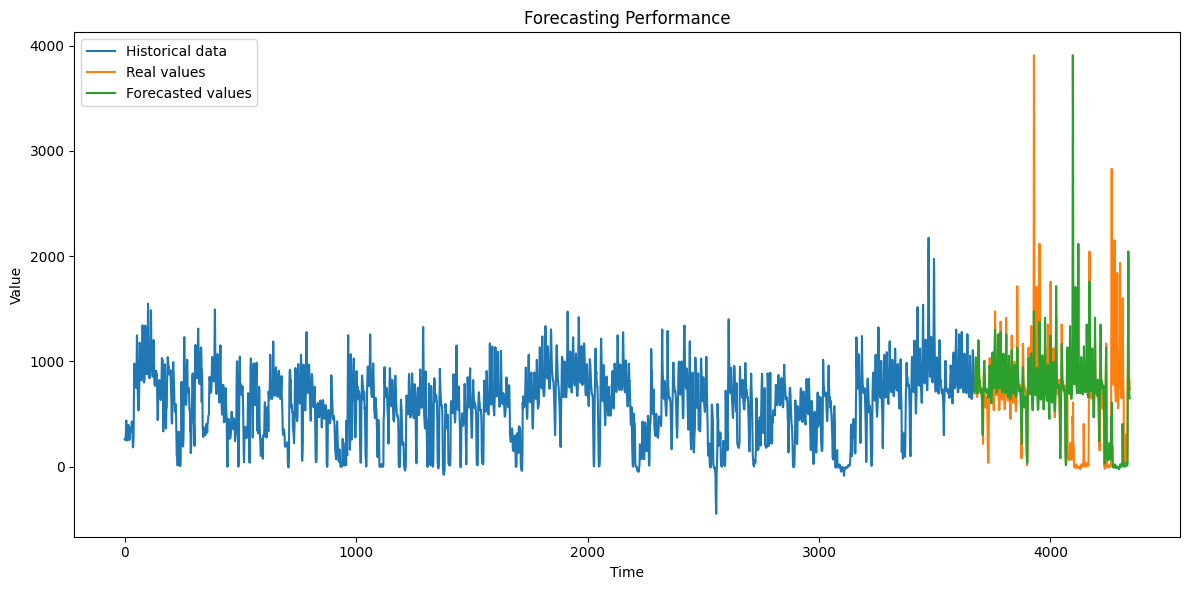

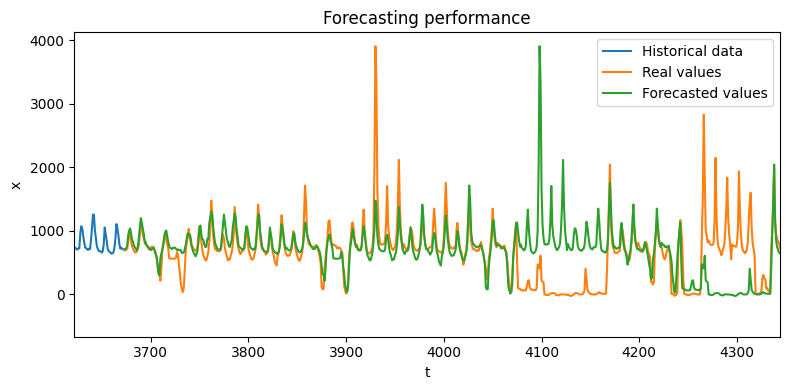

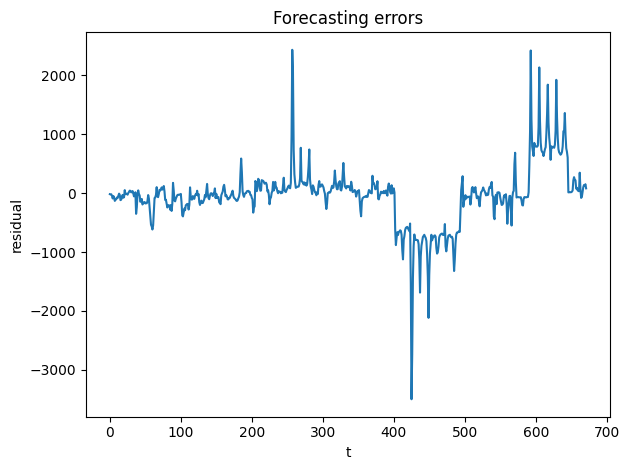

In [ ]:
result = persistence(train['SpotPriceDKK'].values, test['SpotPriceDKK'][0:24*7*4].values, 24*7)
Plotting(train['SpotPriceDKK'].values, test['SpotPriceDKK'][0:24*7*4].values, result)

### Task 2.1 

In [208]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def split_sequence(sequence, n_steps, n_lookahead):
    X, y = [], []
    i = 0
    
    while i + n_steps + n_lookahead <= len(sequence):
        end_ix = i + n_steps
        start_y = end_ix

        # Extract input and output sequences
        seq_x = sequence[i:end_ix]
        seq_y = sequence[start_y:start_y + n_lookahead]

        X.append(seq_x)
        y.append(seq_y)
        
        i += 1

    return np.array(X), np.array(y)

def split_sequence_ext(sequence, all_features, n_steps, n_lookahead):
    """
    Splits a target sequence and external multivariate features into LSTM-compatible input-output pairs
    sequence: array of the target variable
    all_features: array with all features (including sequence)
    """
    X, y = [], []
    i = 0

    while i + n_steps + n_lookahead <= len(sequence):
        end_ix = i + n_steps
        start_y = end_ix

        # Extract input and output sequences
        seq_x = all_features[i:end_ix]
        seq_y = sequence[start_y:start_y + n_lookahead]

        X.append(seq_x)
        y.append(seq_y)

        i += 1

    return np.array(X), np.array(y)

def my_predict(model, data, n_train, n_steps, n_lookahead):
    
    # Create an empty list for the forecasts 
    Forecasts = []
    
    # Number of predictions
    n_test = len(data) - n_train # Test set size
    N = int(n_test/n_lookahead)

    # Simulate real-life operation
    for i in range(0, N):
        # Predict
        x_input = data[n_train+i*n_lookahead-n_steps:n_train+i*n_lookahead].reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        
        # Save the data
        Forecasts.extend(yhat.flatten())
    
    return Forecasts

def my_predict_ext(model, data, n_train, n_steps, n_lookahead, target, features, test_size, shift):
    
    # Create an empty list for the forecasts 
    Forecasts = []
    
    # Number of predictions
    N = int(test_size/n_lookahead)
    
    # Create day-ahead forecasts
    for i in range(0, N):
        # Predict
        x_input = data[n_train+i*n_lookahead-n_steps:n_train+i*n_lookahead].reshape((1, n_steps, data.shape[1]))
        yhat = model.predict(x_input, verbose=0)
                
        # Save the data
        Forecasts.extend(yhat.flatten())
    
    return Forecasts

def LSTM_multilayer(n_steps, n_features, X_train, y_train, n_neurons, 
                    n_neurons_dense, n_lookahead, dropout1, dropout2):
    
    # Define model
    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(n_neurons, activation='relu', return_sequences=True))
    model.add(Dropout(dropout1))  # Dropout layer
    model.add(LSTM(n_neurons, activation='relu'))
    model.add(Dropout(dropout2))  # Dropout layer
    model.add(Dense(n_neurons_dense, activation='relu'))
    model.add(Dense(n_lookahead))
    model.compile(optimizer='adam', loss='mse')
    
    return model
    


def FitLSTM(data, n_steps, n_features, test_size, n_lookahead, n_neurons, 
            n_neurons_dense, epochs, dropout1, dropout2):

    # Split data into training and testing sets based on the specified test size
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Normalize the train and test datasets using MinMaxScaler
    # Define a MinMax scaler that will scale the data between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit the scaler on the training data and apply the transformation to normalize the train set
    train_scaled = scaler.fit_transform(train.reshape(-1, 1))

    # Apply the same scaler (fitted on the training data) to the test set to avoid data leakage
    test_scaled = scaler.transform(test.reshape(-1, 1))

    # Concatenate the normalized training and test data into a single dataset
    # This step is performed after the test data has been scaled with the training scaler
    # This prevents information leakage from the test set during training
    data_scaled = np.concatenate((train_scaled, test_scaled), axis=0)

    # Split the training data into input-output pairs using a sliding window approach
    # X will contain the sequences and y will contain the corresponding targets
    X, y = split_sequence(train_scaled, n_steps, n_lookahead)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape X to be 3D for LSTM input

    # Create a multilayer LSTM model with the specified parameters
    # The model will be built using n_steps, n_features, and other hyperparameters
    model = LSTM_multilayer(n_steps, n_features, X, y, n_neurons, 
                        n_neurons_dense, n_lookahead, dropout1, dropout2)

    # Fit the model on the training data using a validation split of 20%
    # The model will train on 80% of the training data and validate on 20% for each epoch
    history = model.fit(
    X, y, 
    epochs=epochs, 
    validation_split=0.25,  # 20% of training data used for validation
    verbose=1)  # Display progress during training

    # Display the model architecture summary
    model.summary()

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')  # Training loss over epochs
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss over epochs
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')  # Display the legend at the upper right
    plt.grid(True)  # Add a grid for easier visualization of the loss values
    plt.show()

    # Return the trained model and the scaled dataset
    return model, data_scaled

def FitLSTM_ext(data, target, features, n_steps, test_size, n_lookahead, n_neurons, 
            n_neurons_dense, epochs, dropout1, dropout2, shift):

    # Split the data into training and testing sets (no shuffling to preserve time order)
    train, test = train_test_split(data, test_size=test_size, shuffle=False)

    # Normalize the train and test sets
    # We use MinMaxScaler to normalize all columns to the range [0, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit the scaler to the training data and transform it, then apply the same scaling to the test data
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)

    # Fit a separate scaler for the target variable to inverse transform the forecasted values back to original scale
    # This ensures that the predictions we make can be transformed back to the original scale
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit(train[target].values.reshape(-1, 1))
    
    # Combine the scaled training and test data into one dataset
    data_scaled = np.concatenate((train_scaled, test_scaled), axis=0)
    
    # Create input-output pairs using a sliding window approach for sequence forecasting
    # X will contain the lagged values (features and target), and y will contain the target variable for prediction
    X, y = split_sequence_ext(train_scaled[target].values, train_scaled.values,
                              n_steps, n_lookahead) # Adjusted to consider both target and exogenous features

    # Create the LSTM model
    model = LSTM_multilayer(n_steps, len(features)+1, X, y, n_neurons, 
                            n_neurons_dense, n_lookahead, dropout1, dropout2)

    # Fit the model with a 20% validation set from the training data
    history = model.fit(
    X, y, 
    epochs=epochs, 
    validation_split=0.2,  # 20% of the training data will be used for validation
    verbose=1)

    # Display the model architecture and summary
    model.summary()
    
    # Plot the training and validation loss for each epoch to visualize model performance
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
    # Return the model, the scaled data, and the target variable scaler for inverse transformation
    return model, data_scaled, scaler_y

In [209]:
###  Load prosumer data ###
file_PE = os.path.join(os.getcwd(),'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])

file_P = os.path.join(os.getcwd(),'ProdConData.csv')
df_data = pd.read_csv(file_P)
df_data["HourUTC"] = pd.to_datetime(df_data["HourUTC"])


### Merge the dataframes ###
df_merged = pd.merge(df_prices, df_data, on='HourUTC')


train_start = "2022-10-01"
train_end = "2023-08-31"
test_end = "2023-10-1"

df_merged = df_merged.loc[(df_merged['HourUTC']>=train_start) & (df_merged['HourUTC']<=test_end)]
df_merged = df_merged.reset_index(drop=True)
print(df_merged.head())

              HourUTC  SpotPriceDKK  CentralPowerMWh  LocalPowerMWh  \
0 2022-10-01 00:00:00    371.799988              0.0      41.865987   
1 2022-10-01 01:00:00    159.720001              0.0      39.780993   
2 2022-10-01 02:00:00    125.739998              0.0      39.348779   
3 2022-10-01 03:00:00    111.760002              0.0      39.339114   
4 2022-10-01 04:00:00    111.690002              0.0      39.386471   

   CommercialPowerMWh  LocalPowerSelfConMWh  OffshoreWindLt100MW_MWh  \
0          235.490307             15.852854                  19.2591   
1          228.989797             12.721300                  19.1733   
2          143.004609             11.642949                  17.4509   
3          114.022782             12.174353                  17.8530   
4          114.210009             13.137289                  20.0128   

   OffshoreWindGe100MW_MWh  OnshoreWindLt50kW_MWh  OnshoreWindGe50kW_MWh  \
0               576.536661               0.815216             31

In [210]:
# Keep only the target variable 
data = df_merged["SpotPriceDKK"].values


test_size = 720

# Split the dataset into train and test sets (75% train, 25% test)
train, test = train_test_split(data, test_size=test_size, shuffle=False)

# Normalize the data using MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))  # Fit and transform the training data

# No external input features (target only)
n_features = 1

# Define model parameters
n_steps = 24  # The number of time steps the model will look back
n_lookahead = 24  # The number of steps the model will predict ahead
n_neurons = 40  # Number of neurons in the LSTM layer
n_neurons_dense = 20  # Number of neurons in the dense layer
epochs = 40  # Number of training epochs
dropout1 = 0.03  # Dropout rate for the LSTM layer
dropout2 = 0.03  # Dropout rate for the dense layer

# Fit the LSTM model with the defined parameters
model, data_scaled = FitLSTM(data, n_steps, n_features, test_size, n_lookahead, 
                             n_neurons, n_neurons_dense, epochs, dropout1, dropout2)

# Make predictions using the trained model
n_train = len(train)
n_test = len(test)
n_data = n_train + n_test

# Use the model to make predictions on the scaled data
Forecasts = my_predict(model, data_scaled, n_train, n_steps, n_lookahead)

# Inverse transform the scaled predictions to get the actual forecasted values
Forecasts = scaler.inverse_transform(np.array(Forecasts).reshape(-1, 1))

# Calculate persistence forecast: persistence predicts the previous value as the next value
Persistence24 = []
N = int(n_test / n_lookahead)  # Total number of persistence forecast segments
for i in range(N):
    # Here, we take the previous day's data as the predicted value for the current day
    Persistence24.extend(data[len(train)+(i-1)*24:len(train)+i*24])

# Calculate RMSE for persistence and forecast
RMSE_P24 = root_mean_squared_error(Persistence24, test)
RMSE_F = root_mean_squared_error(Forecasts, test)

# Plot the training data, forecasted values, persistence forecast, and actual test values
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(np.arange(1, len(train) + 1), train, color="black")  # Training data
plt.plot(np.arange(n_train + 1, n_data + 1), Forecasts, color="blue")  # Forecasted values
plt.plot(np.arange(n_train + 1, n_data + 1), Persistence24, color="green")  # Persistence forecast
plt.plot(np.arange(n_train + 1, n_data + 1), test, color="red")  # Actual test data
plt.legend(["Training set", "Forecasted values", "Persistence", "Actual values"], 
           loc="upper left", ncol=2)  # Add a legend to the plot
plt.grid(alpha=0.25)  # Add grid for better readability
plt.xlim([len(train)-7*24, len(data)])  # Set the x-axis limits to focus on the forecast period
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

# Print RMSE values for both persistence and forecasted values
print("RMSE for daily persistence: ", round(RMSE_P24, 3))
print("RMSE for forecasts: ", round(RMSE_F, 3))

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.0373 - val_loss: 0.0046
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 3/40
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0071

KeyboardInterrupt: 

#### 2.2

In [ ]:
# Create a copy of the data to be used
# This ensures that any modifications during data preparation don't affect the original dataset
data = df_merged.copy()

# Set the target variable => "PV" in our case
target = "SpotPriceDKK"

# Select your exogenous features
print(data.columns)
features = ["OnshoreWindGe50kW_MWh", "CentralPowerMWh"]

# Keep only the target and exogenous columns
data = data[[target] + features]

# If you want to consider forecasts, shift only the exogenous columns by the n_lookahead horizon
# This is used to align exogenous variables (like temperature and solar radiation) with the forecasted values of the target variable
shift = True

if shift == True:
    data[features] = data[features].shift(-n_lookahead)

In [ ]:
# Define input parameters for the LSTM model
n_steps = 24  # The number of time steps the model will look back
n_lookahead = 24  # The number of steps the model will predict ahead
n_neurons = 40  # Number of neurons in the LSTM layer
n_neurons_dense = 20  # Number of neurons in the dense layer
epochs = 40  # Number of training epochs
dropout1 = 0.03  # Dropout rate for the LSTM layer
dropout2 = 0.03  # Dropout rate for the dense layer

# Train the LSTM model using external features
# Fit the model with the training data, considering the exogenous features
model, data_scaled, scaler_y = FitLSTM_ext(data, target, features, n_steps, test_size, 
                                            n_lookahead, n_neurons, n_neurons_dense, epochs, 
                                            dropout1, dropout2, shift)

# Make predictions using the trained LSTM model
n_train = len(train)  # Number of training data points
n_test = len(test)    # Number of test data points
n_data = n_train + n_test  # Total number of data points (train + test)

# Generate forecasts using the model and the scaled data
Forecasts = my_predict_ext(model, data_scaled, n_train, n_steps, n_lookahead, target, features, test_size, shift)

# Inverse transform the forecasts to get them back to their original scale
# This is done using the scaler_y fitted on the target variable during training
Forecasts = scaler_y.inverse_transform(np.array(Forecasts).reshape(-1, 1))

# Forecast with persistence (using the last observed value for the next time step)
Persistence24 = []
N = int(n_test / n_lookahead)  # Number of persistence steps based on lookahead

# Generate persistence forecast by extending the target variable's values (shifted by 24 steps)
for i in range(N):
    Persistence24.extend(data["SpotPriceDKK"][len(train) + (i - 1) * 24 : len(train) + i * 24])

# Calculate the RMSE (Root Mean Squared Error) for the persistence and forecasted values
RMSE_P24 = root_mean_squared_error(Persistence24, test)  # RMSE for persistence
RMSE_F = root_mean_squared_error(Forecasts, test)  # RMSE for the forecasted values

# Plot the forecasts to visually compare the training data, forecasts, and actual test data
plt.figure(figsize=(10, 4), dpi=100)
plt.plot(np.arange(1, len(train) + 1), train, color="black")  # Training data
plt.plot(np.arange(n_train + 1, n_data + 1), Forecasts, color="blue")  # Forecasted values
plt.plot(np.arange(n_train + 1, n_data + 1), Persistence24, color="green")  # Persistence forecast
plt.plot(np.arange(n_train + 1, n_data + 1), test, color="red")  # Actual test data
plt.legend(["Training set", "Forecasted values", "Persistence", "Actual values"], loc="upper left")  # Legend
plt.grid(alpha=0.25)  # Light gridlines for better readability
plt.xlim([len(train) - 7 * 24, len(data)])  # Set the x-axis limits (focus on the last 7 days of the data)
plt.tight_layout()  # Make sure the plot fits within the window
plt.show()  # Display the plot

# Print the RMSE values for persistence and the forecast to assess the model's performance
print("RMSE for daily persistence: ", round(RMSE_P24, 3))  # RMSE for persistence forecast
print("RMSE for forecasts: ", round(RMSE_F, 3))  # RMSE for the model's forecasted values

#### 4 

In [29]:
# %% Importing Libraries
import cvxpy as cp
def simulation(
    consumption: np.ndarray,
    buy: np.ndarray,
    sell: np.ndarray,
    energy_capacity,
    power_capacity,
    charging_efficiency=1,
    discharging_efficiency=1,
    SOC_start=0.5,
    SOC_min=0,
    SOC_max=1,
    SOC_end=None,
    production=None,
):
    ### Define the given parameters ###
    ## SOC limits
    P_max = power_capacity  # kW
    capacity = energy_capacity  # kWh
    ## Efficiencies
    eta_c = charging_efficiency  # Charging efficiency
    # Inverse of the discharge efficiency to avoid division
    eta_d_inv = 1 / discharging_efficiency
    ## Initial and final SOC
    C0 = SOC_start * capacity
    ### Data series
    ## EOD indicator for the last hour of the day
    ## Energy Surplus and shortage

    ### Create the optimization variables
    ## Number of steps in the optimization = number of hours in data
    n = len(consumption)
    ## Charging and discharging power per hour
    p_c = cp.Variable(n)
    p_d = cp.Variable(n)
    ## Import and export power per hour
    imp = cp.Variable(n)
    exp = cp.Variable(n)
    ## Battery state of charge per hour
    X = cp.Variable(n)
    d = cp.Variable(n, boolean=True)

    if production is None:
        production = np.zeros(n)
    else:
        consumption = consumption + (-production).clip(0)
        production = production.clip(0)

    ### Define the variable to be optimized
    cost = cp.sum(-exp @ sell + imp @ buy)

    ### Define the constraints
    constraints = [
        ## Power constraints
        p_c >= 0,
        p_d >= 0,
        imp >= 0,
        exp >= 0,
        p_c <= P_max * d,
        p_d <= P_max * (1 - d),
        ## Relationship between import/export and charging/discharging
        ## Sum of battery power and shortage/surplus must equal import/export
        production + p_d + imp == p_c + consumption + exp,
        ## State of charge constraints
        # Charging in initial time step
        X[0] == C0 + p_c[0] * eta_c - p_d[0] * eta_d_inv,
        # SOC limits
        X >= SOC_min * capacity,
        X <= SOC_max * capacity,
    ]
    if SOC_end is not None:
        X[-1] == SOC_end * capacity
    ### Make SOC time steps
    print("making steps")
    for i in range(1, n):
        constraints += [X[i] == X[i - 1] + p_c[i] * eta_c - p_d[i] * eta_d_inv]
    ### Create the optimization problem as a minimization problem
    print("making problem")
    problem = cp.Problem(cp.Minimize(cost), constraints)
    ### Solve the optimization problem
    print("solving")
    problem.solve()
    print("done")
    print(problem.status)
    print(problem.value)
    battery_power = p_c.value - p_d.value
    net_import = imp.value - exp.value
    hourly_cost = -exp.value * sell + imp.value * buy
    return pd.DataFrame(
        {
            "Battery Charging [kW]": battery_power,
            "Import from grid [kWh]": net_import,
            "PV Production [kWh]": production,
            "Consumption [kWh]": consumption,
            "Buy Price [DKK/kWh]": buy,
            "Sell Price [DKK/kWh]": sell,
            "Cost [DKK]": hourly_cost,
            "SOC": X.value / capacity,
            "PV part": production / (production + imp.value + p_d.value),
            "Bat part": (p_d.value) / (production + imp.value + p_d.value),
            "Grid part": (imp.value) / (production + imp.value + p_d.value),
        }
    )




In [206]:
#Introducing a function to handle daily looping 

def evaluate_battery_strategy(
    prices,  # Actual spot prices, shape: (720,)
    consumption=None,  # Optional, defaults to zero
    production=None,  # Optional
    energy_capacity=2,  # MWh
    power_capacity=1,  # MW
    charging_efficiency=0.95,
    discharging_efficiency=0.95,
    SOC_init=0.5,
    SOC_min=0.1,
    SOC_max=1.0,
    SOC_EOD = 0.1
):
    n_days = 30
    hours_per_day = 24
    total_hours = n_days * hours_per_day

    if consumption is None:
        consumption = np.zeros(total_hours)
    if production is None:
        production = np.zeros(total_hours)

    # Store daily profits
    profits = []
    SOC = SOC_init

    for day in range(n_days):
        idx_start = day * 24
        idx_end = idx_start + 24

        cons = consumption[idx_start:idx_end]
        prod = production[idx_start:idx_end]

        # Simulate battery schedule
        df = simulation(
            consumption=cons,
            buy=prices[idx_start:idx_end],
            sell=prices[idx_start:idx_end],
            energy_capacity=energy_capacity,
            power_capacity=power_capacity,
            charging_efficiency=charging_efficiency,
            discharging_efficiency=discharging_efficiency,
            SOC_start=SOC,
            SOC_min=SOC_min,
            SOC_max=SOC_max,
            SOC_end=SOC_EOD,  # Free to choose
            production=prod
        )

        # Use true prices to calculate actual profit
        profit = -df["Cost [DKK]"].sum()
        profits.append(profit)

        # Update SOC for next day
        SOC = df["SOC"].values[-1]

    return {
        "total_profit": np.sum(profits),
        "daily_profits": profits
    }

file_PE = os.path.join(os.getcwd(),'Elspotprices2nd.csv')
df_prices = pd.read_csv(file_PE)
df_prices["HourUTC"] = pd.to_datetime(df_prices["HourUTC"])
actual_prices =df_prices.loc[df_prices["HourUTC"]>='09-01-2024']
actual_prices = actual_prices.loc[actual_prices['HourUTC']<'10-01-2024']

# First, simulate perfect knowledge:
result_perfect = evaluate_battery_strategy(prices=actual_prices['SpotPriceDKK'].values)


print("Total profit (perfect):", result_perfect["total_profit"])



making steps
making problem
solving
done
optimal
-2142.4794454050007
making steps
making problem
solving
done
optimal
-2269.9456550510536
making steps
making problem
solving
done
optimal
-3643.18042893
making steps
making problem
solving
done
optimal
-3029.130611855264
making steps
making problem
solving
done
optimal
-946.4281858410525
making steps
making problem
solving
done
optimal
-2077.9794792357898
making steps
making problem
solving
done
optimal
-1798.0272271068422
making steps
making problem
solving
done
optimal
-1613.4597448773688
making steps
making problem
solving
done
optimal
-1081.4643229352641
making steps
making problem
solving
done
optimal
-1286.7982380742105
making steps
making problem
solving
done
optimal
-2298.487635864737
making steps
making problem
solving
done
optimal
-3036.659675707369
making steps
making problem
solving
done
optimal
-1399.6233412689476
making steps
making problem
solving
done
optimal
-2155.141007559474
making steps
making problem
solving
done
opt